# Speaker-Independent Spoken Digit Recognition (xSDR)


One of the successful stories of deep neural networks is the proliferation of commercial of automatic speech recognition (ASR) systems. This project aims to explore one application of ML-powered ASR to the problem of spoken digit recognition (SDR). Since digits are widely used as unique identifiers for bank information, social security numbers, post codes, etc, SDR systems can be an efficient alternative to fully-fledged ASR systems since the domain is more predictable than other applications of ASR.

In this project, we focus on developing a SDR system in a speaker-independent setting. That is, the speakers in the evaluation set are disjoint from the training set speakers. We do so because we expect real-world ASR systems to generalize to different speakers than those we have data for. Moreover, for many languages that are under-resourced, we have have (limited) annotated speech data from a single speaker, but we would still want the system to be deployed to work on any speaker of that language. We tackle the problem of spoken digit recognition as a sequence classification task. Concretely, the inputs are short audio clips of a specific digit (in the range 0-9), then the goal is to build deep neural network models to classify a short audio clip and predict the digit that was spoken.

# Notes

## Code Submission

You don't necessarily need to complete the code in this Jupyter Notebook, you are free to use another notebook or a python script file, as you would like. You are expected to submit the code by **22.03.2023**.

Your code should be clean and well commented. We also expect that if we decide to run it on our system, it should be straighforward to do so. We recommend creating a ```requirements.txt``` file with the names of all the libraries with their versions. If applicable, please mention the python version in a ```README.md``` file, which should also include instructions on how to run your code.

As mentioned for the assignments, always remember to cite the code with the links as comments, if you decide to use it from a public repository.

## Report Submission

With the code, you are also expected to submit a report with a maximum of 4 pages. You should write your report in LaTeX using this template for ACL 2023 [Overleaf Link](https://www.overleaf.com/latex/templates/acl-2023-proceedings-template/qjdgcrdwcnwp). Use this document to fill in any missing information that are not necessarily covered during your presentation for the sake of time in the presentation. While writing your report, we would highly encourgae you to cite the papers behind each tool / library / function that you might use for your experiments. We have also released an example on how to write equations in LaTeX [here](https://piazza.com/class/l9so16qqvk34hu/post/52).

You art also expected to submit this report with your code. You should provide the **.tex, .pdf and all image files** zipped with the same naming convention as it was in your assignment(s).

## Presentation

During the last week of March 2023, i.e. 27.03 -- 31.03, each team will be presenting their works for 15 minutes. We expect equal contribution from each member in delivery and content of the presentation. So roughly 5 minutes for one person, if you have 3 people in your team. There will be 5 minutes for some Q&A. At-least one person from your team should be present to do an in-person presentation, rest of your team could join remotely, if they are not present.

## Important Dates

 - Code & Report Submission: 22.03.2023 (08.00)
 - Presentation: 27.03.2023 -- 31.03.2023

 You'll get a precise date and time for your team's presentation at a later time.

### Grading

In this project, your final grades will be determined as follows:

 - **30%**: &emsp; Completing all the tasks
 - **30%**: &emsp; Providing scientific-backings for all the methods used
 - **20%**: &emsp; Quality of the content of the presentation
 - **20%**: &emsp; Delivery of the presentation

In [ ]:
#%matplotlib inline
import numpy as np
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import torch
import pandas as pd

from sklearn  import preprocessing


from collections import defaultdict, Counter

# add this to ignore warnings from Librosa
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import random

In [ ]:
# for linear models
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE as tsne

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
torch.cuda.is_available()
device = torch.device("cuda")

## Exploring the Dataset

The speech samples are already divied into training, development, and test spilts. The splits are made in such way that evaluation speakers are not present in training split. You should use the splits as they are.

**CAUTION:**

In this project, you are not allowed to use any external data for this problem (at least for the main three tasks). Exploring the effect of additional datasets in this project can only included as a further step after completing the main requirements with the given data.

In [ ]:
# read tsv file into a dataframe
sdr_df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')

In [ ]:
sdr_df.head(100)

,identifier,speaker,split,label,file
0,5_theo_23,theo,TRAIN,5,speech_data/5_theo_23.wav
1,2_yweweler_39,yweweler,TEST,2,speech_data/2_yweweler_39.wav
2,6_yweweler_34,yweweler,DEV,6,speech_data/6_yweweler_34.wav
3,6_yweweler_16,yweweler,DEV,6,speech_data/6_yweweler_16.wav
4,9_yweweler_2,yweweler,TEST,9,speech_data/9_yweweler_2.wav
...,...,...,...,...,...
95,1_nicolas_26,nicolas,TRAIN,1,speech_data/1_nicolas_26.wav
96,3_jackson_18,jackson,TRAIN,3,speech_data/3_jackson_18.wav
97,0_yweweler_41,yweweler,DEV,0,speech_data/0_yweweler_41.wav
98,9_yweweler_22,yweweler,DEV,9,speech_data/9_yweweler_22.wav


In [ ]:
set(sdr_df.speaker.values)

{'george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler'}

In [ ]:
# explore one sample: 7_theo_0
sdr_df.loc[sdr_df['identifier'] == '7_theo_0']

,identifier,speaker,split,label,file
700,7_theo_0,theo,TRAIN,7,speech_data/7_theo_0.wav


In [ ]:
sample_wav_file = sdr_df.loc[sdr_df['identifier'] == '7_theo_0'].file[700]

## The Speech Waveform

The acoustic realization of speech segment can be (digitally) viewed as a time-variant wavform $\mathbf{S} \in \mathbb{R}^{n}$. Here, $n$ depends on both the duration of the speech segment and the sampling rate of the continous speech singal. Let's check out one sample from the data set.

In [ ]:
# play and listen to a sample
SAMPLING_RATE = 8000 # This value is determined by the wav file, DO NOT CHANGE

x, sr = librosa.load(sample_wav_file, sr=SAMPLING_RATE) #,
ipd.Audio(x, rate=sr)

In [ ]:
x.shape

(3428,)

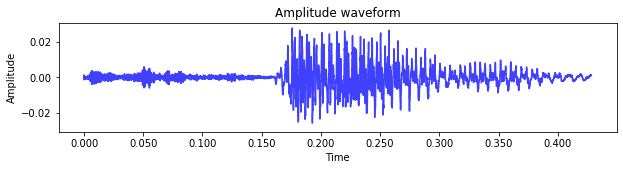

In [ ]:
# plot as a waveform
fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.waveshow(y=x, sr=sr, alpha=0.75, x_axis='time', color='blue')

ax.set(title='Amplitude waveform')
ax.set_ylabel('Amplitude')
ax.label_outer()

In [ ]:
# sample duration in milliseconds
(1000*len(x))/SAMPLING_RATE

428.5

In the cell above, you can see the temporal duration of the audio is 428.5 milliseconds. For digits in the range 0-9, the duration of the speech segment should be around 0.5 seconds with reasonable variation depending on speech rate (i.e., how fast the speaker speaks).

## The Speech Signal Representation - Mel Spectrograms

Humans can recognize and differentiate different speech sounds based on the frequency characteristics of the sounds. For machine learning applications, human speech is represented using spectro-temporal features in the [Mel-scale](https://en.wikipedia.org/wiki/Mel_scale) extracted from the speech sample. Mel-scale features are inspired by human speech perception and auditory processing whereby the human ear has difference sensitivity (or resolution) in differet frequency bandes. That is, the human ear can better recognize differences in in lower range frequences, while higher range frequences have a lower resolution. The Mel-scale is linear for frequencies in the range (0-1kHz), and logarithmic for frequencies above 1kHz.

In the spectro-temporal representation of speech, a speech sample can be seen as a sequence of $T$ spectral vectors as $\mathbf{X} = (\mathbf{x}^1, \mathbf{x}^2, \dots, \mathbf{x}^T)$. Each spectral vector $\mathbf{x}^t \in \mathbb{R}^{k}$ at time-step $t$ is extracted from a short speech segment (~25 milliseconds) with the assumption that the signal is time-invariant in this small time window. Here, $k$ is the number of frequency bands in the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) and this is a parameter of the feature extraction pipeline. The representation is based on the Fourier transform to convert the temporal signal into the frequency domain.

In automatic speech recognition (ASR) research and applications, spectral vectors are usually referred to as "acoustic frames". Morover, adjacent frames are extracted with some overlap between them, usually ~10 milliseconds.

In [ ]:
def extract_melspectrogram(signal, sr, num_mels):
    """
    Given a time series speech signal (.wav), sampling rate (sr),
    and the number of mel coefficients, return a mel-scaled
    representation of the signal as numpy array.
    """

    mel_features = librosa.feature.melspectrogram(y=signal,
        sr=sr,
        n_fft=200, # with sampling rate = 8000, this corresponds to 25 ms
        hop_length=80, # with sampling rate = 8000, this corresponds to 10 ms
        n_mels=num_mels, # number of frequency bins, use either 13 or 39
        fmin=50, # min frequency threshold
        fmax=4000 # max frequency threshold, set to SAMPLING_RATE/2
    )

    # for numerical stability added this line
    mel_features = np.where(mel_features == 0, np.finfo(float).eps, mel_features)

    # 20 * log10 to convert to log scale
    log_mel_features = 20*np.log10(mel_features)

    # feature scaling
    scaled_log_mel_features = preprocessing.scale(log_mel_features, axis=1)

    return scaled_log_mel_features

In [ ]:
melspectrogram = extract_melspectrogram(x, sr, num_mels=13)

melspectrogram.shape

(13, 43)

Note that the shape of the array (K x T) represents the number of frequency bands (K) and the number of spectral vectors in this representation (here, K=13, T=43). K is a hyperparameter and the recommended values in ASR research are (13, 39, 81, etc). Here, we fix K = 13. On the other hand, T varies from sample to sample depending on the duration of the sample.  

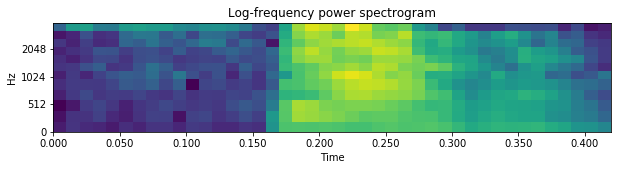

In [ ]:
# plot and view the spectrogram

fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.specshow(
    melspectrogram,
    sr=sr,
    x_axis='time',
    y_axis='mel',
    cmap='viridis',
    fmax=4000,
    hop_length=80
)

ax.set(title='Log-frequency power spectrogram')

ax.label_outer()

As you can see above from the figure, the spectrogram representation can be viewed as a matrix $\mathbf{X} \in \mathbb{R}^{T} \times \mathbb{R}^{k}$.  

## Task I
1. One problem with the spectrogram as a speech feature represetation is that different speech samples would have dfferent durations due to inherent speech variability (e.g., speech rate, speaker dialect, etc). That is, the $T$ in the $(T \times k)$-dimensional representation would be different for each sample. Therefore, for the baseline model, we will implement a method to have a fixed-size representation for all speech samples. Write a function downsample_spectrogram(X, N) that takes as input a spectrogram $\mathbf{X} \in \mathbb{R}^{T \times k}$ and a parameter N <= 25. The function should (1) make N equally-sized splits of S across the time-axis, (2) apply a pooling technique (e.g., mean pooling) to each split across the frequency axis to obtain an array that represents a downsampled version of the spectrogram $\mathbf{X}' \in \mathbb{R}^{N \times k}$, and (3) re-arange $\mathbf{X}'$ as a vector $\mathbf{v} \in \mathbb{R}^{Nk}$.    

2. Using the downsample_spectrogram(X, N) function, transform all the speech samples into vectors $\mathbf{v} \in \mathbb{R}^{Nk}$.

3. Given the speaker-based train/dev/test spilts in the SDR_metadata.tsv, fit a linear model on the training samples. That is, your model should be build on data from 4 speakers {'nicolas', 'theo' , 'jackson',  'george'}. Hint: you can experiment with a few model alternatives in the SGDClassifier module in scikit-learn.

4. Evaluate you model on the dev and test splits. Use accuracy as an evaluation metric. Analyze the model performance using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of the all possible labels (0-9), Analyze [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall), [F1-score](https://en.wikipedia.org/wiki/F-score) for each label. Report your observation.

## Baseline Model

In [ ]:
def maxmin(x):
    maxi=np.max(x)
    mini=np.min(x)
    if abs(maxi)>abs(mini):
        return maxi
    elif abs(maxi)<=abs(mini):
        return mini

In [ ]:
x=np.random.randn(5)
print("input array:\n",x)
print("output:\n")
print(maxmin(x))

input array:
 [ 1.70585957 -0.46338947  0.44039307  0.36269289 -1.66556403]
output:

1.7058595668138559


In [ ]:
def downsample_spectrogram(X, N):
    """
    Given a spectrogram of an arbitrary length/duration (X ∈ K x T),
    return a downsampled version of the spectrogram v ∈ K * N
    """
    # ... your code here
    x=X
    lrb = N-x.shape[1]%N #remaining values
    zp=np.zeros((x.shape[0],lrb))
    x=np.concatenate((x,zp),axis=1)
    zX = np.zeros((x.shape[0],N))
    #number of split
    wsn = int(x.shape[1]/N) #within split population
    for i in range(x.shape[0]):
        for j in range(N):
            zX[i,j] = maxmin(x[i,j*wsn:(j+1)*wsn])

    X=torch.tensor(zX).view(1,-1)
    X=X.numpy()
    return X

In [ ]:
downsample_spectrogram(melspectrogram,25).shape

(1, 325)

In [ ]:
# prepare data and split
N=25
dummy=np.zeros((1,N*13))
datadict = {'TRAIN':dummy,'DEV':dummy,'TEST':dummy}
labeldict = {'TRAIN':[],'DEV':[],'TEST':[]}
for path,split,label in tqdm(zip(sdr_df['file'],sdr_df['split'],sdr_df['label'])):
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
        data=downsample_spectrogram(melspectrogram, N)
        datadict[split]=np.concatenate((datadict[split],data),axis=0)
        labeldict[split].append(label)
train_data = datadict['TRAIN'][1:]
test_data = datadict['TEST'][1:]
val_data = datadict['DEV'][1:]
train_y = labeldict['TRAIN']
test_y = labeldict['TEST']
val_y = labeldict['DEV']

3000it [00:16, 179.74it/s]


In [ ]:
# train a linear model
PPD = StandardScaler()
PPD.fit(train_data)
Xtrain = PPD.transform(train_data)
Xtest = PPD.transform(test_data)
Xdev = PPD.transform(val_data)
#model defined
model1 = SGDClassifier(loss="log",penalty='elasticnet',l1_ratio=0.15,alpha=0.0001,max_iter=1000)
#model training
model1.fit(Xtrain, train_y)
print(f'The accuracy on validation set: {accuracy_score(val_y, model1.predict(Xdev))*100}%')

#tuning of hyperparameter using the dev set

acc=0
lam=0
l1r=0
lambdas = [0.1,0.01,0.005,0.001,0.0005,0.0001]
l1_rat = [0.15,0.25,0.35]


for l1_r in l1_rat:
    for l in lambdas:
        model1 = SGDClassifier(loss="log",penalty='elasticnet',l1_ratio=l1_r,alpha=l,max_iter=1000)
        model1.fit(Xtrain, train_y)
        if acc < accuracy_score(val_y, model1.predict(Xdev)):
            lam=l
            l1r=l1_r
            acc=accuracy_score(val_y, model1.predict(Xdev))



# model trained with optimal parameter
model1 = SGDClassifier(loss="log",penalty='elasticnet',l1_ratio=l1r,alpha=lam,max_iter=1000)
model1.fit(Xtrain, train_y)
print(f'The accuracy on train set: {accuracy_score(train_y, model1.predict(Xtrain))*100}%')
print(f'the best validation accuracy achieved is:{accuracy_score(val_y, model1.predict(Xdev))*100}%\n')
print(f'the optimal regularisation value acheived is: {lam}\n')
print(f'the optimal l1 ratio is :{l1r}\n')

# evaluate the model using accuracy metric on test set
print(f'\nThe accuracy on test set: {accuracy_score(test_y, model1.predict(Xtest))*100}%')
# analyze the confusion matrix of the baseline
print('\nConfusion Matrix onn the test data \n', confusion_matrix(test_y,model1.predict(Xtest)))
# report precision, recall, F1-score for each label
print("\nThe Classification Report for test set classification\n",classification_report(test_y, model1.predict(Xtest), labels=list(range(10))))






The accuracy on validation set: 34.80885311871227%
The accuracy on train set: 95.39999999999999%
the best validation accuracy achieved is:35.2112676056338%

the optimal regularisation value acheived is: 0.0001

the optimal l1 ratio is :0.35


The accuracy on test set: 40.15904572564612%

Confusion Matrix onn the test data 
 [[26  0  3  0  0  0  7 15  0  2]
 [ 0 26  0  0  0  0 18  6  2  3]
 [ 0  0  8  1  0  1 30 13  1  0]
 [ 0  0  0  7  1  0 30  1  0  7]
 [ 0  1  1  2  8  0 17 15  0  2]
 [ 0  0  0  1  1 13 30  4  0  1]
 [ 0  0  0  1  0  0 40  2  0  3]
 [ 0  0  0  1  0  1 14 30  1  0]
 [ 0  1  1  0  1  1 29  3 19  1]
 [ 0  1  0  0  0  6 13  4  1 25]]

The Classification Report for test set classification
               precision    recall  f1-score   support

           0       1.00      0.49      0.66        53
           1       0.90      0.47      0.62        55
           2       0.62      0.15      0.24        54
           3       0.54      0.15      0.24        46
           4    

In [ ]:
X_emb =tsne(n_components=2,init='random', perplexity=3).fit_transform(Xtest)

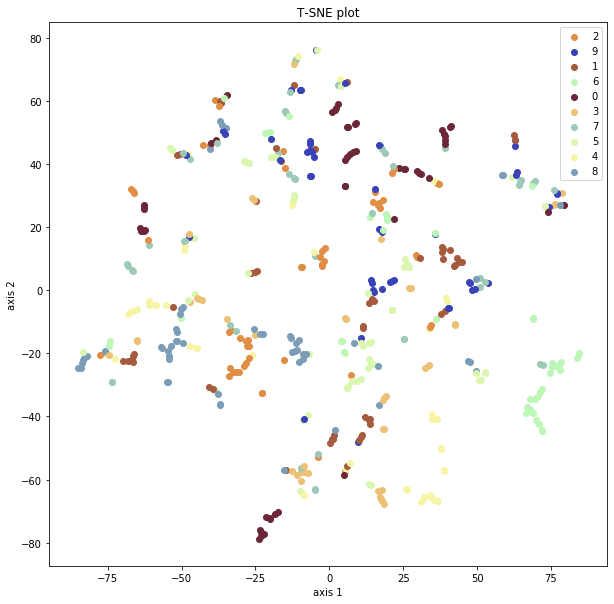

In [ ]:
labels=torch.tensor(test_y)
color_dict={0:'#6B2737',1:'#A65B3E',2:'#E08E45',3:'#ECC176',4:'#F8F4A6',5:'#DBF6AF',6:'#BDF7B7',7:'#9CCAB7',8:'#7B9DB7',9:'#3943B7'}
fig=plt.figure(figsize=(10,10))
rec=[]
for i in range(X_emb.shape[0]):
    if labels[i].item() not in rec:
        rec.append(labels[i].item())
        plt.scatter(X_emb[i][0],X_emb[i][1],color=color_dict[labels[i].item()],label=str(labels[i].item()))
    else:
        plt.scatter(X_emb[i][0],X_emb[i][1],color=color_dict[labels[i].item()])
plt.xlabel("axis 1")
plt.ylabel("axis 2")
plt.title("T-SNE plot")
plt.legend()

## Task II
1. Having established a baseline with a linear model trained on a downsampled signal representation of the speech segment, this task aims to learn a classifier based on the full speech segment. To this end, you will implement a neural model that is suitable for sequential data such as recurrent DNN, convolutional DNN with 1-D temporal convolution, or an audio transformer. The model should take the acoustic sample as it is (i.e., the Mel spectrogram could have an arbitrary length) without the need to downsample the segment. You need to implement at least two of the aforementioned models. Do the neural models improve accuracy over the baseline model? Do you observe any signs of overfitting to the training data? How do the hyperparameters affect the model performance? Report and discuss your observations.        

2. Evaluate your (best) neural models and compare to the baseline model using the same evalution process as in task I.4.

3. Use a dimensionality reduction algorithm such as t-SNE \[[1](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding),[2](https://pypi.org/project/tsne-torch/),[3](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)\] or [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) to analyze how the different models seperate the different classes (the last non-linear layer in your model). Compare to the downsampled representation you used in the baseline and report your observations.

4. Are the differences between the different models statistically significant? To answer this question, you need to implement a statistical significance test based on bootstrapping method. To read more how to estiame p-values based on bootstrapping, we recommend the materials on this paper https://aclanthology.org/D12-1091.pdf. Include the baseline model in your evaluation.

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
from tqdm import tqdm
from torchmetrics import F1Score
from torch.utils.data import Dataset,DataLoader
from tsne_torch import TorchTSNE as TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

In [ ]:
###Helper function
#calculating loss over a dataset
def test(model,test_loader):
        loss_fn = nn.CrossEntropyLoss()
        loss=0
        for i,(xs,ys) in enumerate(test_loader):
            xs=xs.to(device)
            ys=ys.to(device)
            pred = model.forward(xs.type(torch.FloatTensor).cuda())
            loss+= loss_fn(pred,ys).item()
        print(loss/len(test_loader))
        return (loss/len(test_loader))
##function to get accuracy:
def get_accuracy(data,model):
    accdata=data
    train_acc=0
    i=0
    for X,Y in accdata:
        i+=len(X)
        X=X.to(device)
        Y=Y.to(device)
        ypred=model.forward(X.type(torch.FloatTensor).cuda())
        train_acc += torch.sum(ypred.argmax(1) == Y)
    accuracy = train_acc/i

    print(accuracy.item()*100,"%")
    return (accuracy.item())

def get_f1(data,model):
    accdata=data
    F1=0
    i=0
    for X,Y in accdata:
        i+=len(X)
        X=X.to(device)
        Y=Y.to(device)
        f1= F1Score(task="multiclass", num_classes=10).to(device)
        ypred=model.forward(X.type(torch.FloatTensor).cuda())
        f1 = f1(ypred.argmax(1),Y)
        F1+=f1.item()
    print("F1 score:",F1/i)
    return (f1.item())

def plot(lossrec,par):
    fig, axs = plt.subplots(1,2,figsize=(20,7))
    axs[0].set_title('epoch vs log loss')
    axs[0].plot(range(len(lossrec)),lossrec,color='orange',label='Training loss')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('log loss')
    axs[1].plot(range(len(par)),par,marker='o',color='violet',label='weight grad')
    axs[1].set_ylabel('norm of weights grad')
    axs[1].set_xlabel('epochs')
    axs[1].set_title('change of weight grad over epochs ')
    axs[1].legend()
    plt.show()
def create_embedding(data,model):
    accdata=data
    train_acc=0
    i=0
    YP=torch.ones(1,10)
    Ys=[]
    for X,Y in accdata:
        ypred=model.forward(X.type(torch.FloatTensor).cuda())
        YP=torch.tensor(np.concatenate((YP,ypred.detach().cpu().numpy()),axis=0))
        Ys+=Y
    return YP[1:],Ys

def tsne_map(testdl2,modellstm):
    embeds,labels=create_embedding(testdl2,modellstm)
    X_emb = tsne(n_components=2,init='random', perplexity=3).fit_transform(embeds.cpu().detach().numpy())
    color_dict={0:'#6B2737',1:'#A65B3E',2:'#E08E45',3:'#ECC176',4:'#F8F4A6',5:'#DBF6AF',6:'#BDF7B7',7:'#9CCAB7',8:'#7B9DB7',9:'#3943B7'}
    fig=plt.figure(figsize=(10,10))
    rec=[]
    for i in range(X_emb.shape[0]):
        if labels[i].item() not in rec:
            rec.append(labels[i].item())
            plt.scatter(X_emb[i][0],X_emb[i][1],color=color_dict[labels[i].item()],label=str(labels[i].item()))
        else:
            plt.scatter(X_emb[i][0],X_emb[i][1],color=color_dict[labels[i].item()])
    plt.xlabel("axis 1")
    plt.ylabel("axis 2")
    plt.title("T-SNE plot")
    plt.legend()
def confusionplot(data,model):
    accdata=data

    YP=[]
    Ys=[]
    for X,Y in accdata:
        X=X.to(device)
        y_pred=torch.argmax(model.forward(X.type(torch.FloatTensor).cuda()),dim=1)
        YP+=y_pred.cpu()
        Ys+=Y
    cf_matrix = confusion_matrix(Ys, YP)
    classes = (0,1,2,3,4,5,6,7,8,9)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,10))
    sn.heatmap(df_cm, annot=True)
def classificationReport(data,model):
    accdata=data
    YP=[]
    Ys=[]
    for X,Y in accdata:
        X=X.to(device)
        y_pred=torch.argmax(model.forward(X.type(torch.FloatTensor).cuda()),dim=1)
        YP+=y_pred.cpu()
        Ys+=Y
    print(classification_report(Ys, YP, labels=list(range(10))))

In [ ]:
class customDataset(Dataset):
    def __init__(self, datalist, labels):
        self.labels = labels
        self.datalist = datalist

    def __len__(self):
        return self.datalist.shape[0]

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.datalist[idx]
        return data, label


class customDataLoader(DataLoader):
    def __init__(self, customdata, batch_size, collate_fn=None):
        self.customdata = customdata
        self.batch_size = batch_size

    def loader(self):
        return DataLoader(self.customdata, self.batch_size)

In [ ]:
## data processing

# determining the longest sequence
maxlength=0
for path,split,label in zip(sdr_df['file'],sdr_df['split'],sdr_df['label']):
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
        if maxlength < melspectrogram.shape[1]:
            maxlength = melspectrogram.shape[1]
print(maxlength)

229


In [ ]:
max_val = -np.inf
for path, split, label in zip(sdr_df['file'], sdr_df['split'], sdr_df['label']):
    x, sr = librosa.load(path, sr=SAMPLING_RATE)
    melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
    if np.max(melspectrogram) > max_val:
        max_val = np.max(melspectrogram)

### Model 1: 1D CNN based

In [ ]:
dummy=np.zeros((1,melspectrogram.shape[0],maxlength+27))
datadict = {'TRAIN':dummy,'DEV':dummy,'TEST':dummy}
labeldict = {'TRAIN':[],'DEV':[],'TEST':[]}
for path,split,label in zip(sdr_df['file'],sdr_df['split'],sdr_df['label']):
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1)
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)
train_data = datadict['TRAIN'][1:]
test_data = datadict['TEST'][1:]
val_data = datadict['DEV'][1:]
train_y = labeldict['TRAIN']
test_y = labeldict['TEST']
val_y = labeldict['DEV']

In [ ]:
custom_train_dataset = customDataset(train_data, train_y)
custom_train_loader = customDataLoader(custom_train_dataset, batch_size=32)
traindl = custom_train_loader.loader()

custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=503)
testdl = custom_test_loader.loader()

custom_val_dataset = customDataset(val_data, val_y)
custom_val_loader = customDataLoader(custom_val_dataset, batch_size=32)
valdl = custom_val_loader.loader()

In [ ]:
class cnnModel(nn.Module):
    def __init__(self, input_dim, kernel_size,d):
        super(cnnModel, self).__init__()
        self.input_dim = input_dim
        self.k_size = kernel_size
        self.d=d
        layers = []
        layers.append(nn.Conv1d(in_channels=self.input_dim, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))


        layers.append(nn.Conv1d(in_channels=26, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=52, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(52))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))


        layers.append(nn.Conv1d(in_channels=52, out_channels=104, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=104, out_channels=104, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(104))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))

        layers.append(nn.Conv1d(in_channels=104, out_channels=104, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=104, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(52))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))


        layers.append(nn.Conv1d(in_channels=52, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=52, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))

        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))


        self.conv_layers = nn.Sequential(*layers)

        self.fc_layers = nn.Sequential(
            nn.Linear(26 * 4, 350, bias=True),
            nn.ReLU(),
            nn.Linear(350, 10, bias=True),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Reshape input tensor to be compatible with convolutional layers
        x = self.conv_layers(x.type(torch.FloatTensor).cuda())
        x = x.view(x.size(0), -1)  # Flatten tensor

        # Feed flattened tensor through fully connected layers
        x = self.fc_layers(x)

        return x

    def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01,opti='adam'):
        optidict={'adagrad':torch.optim.Adagrad(self.parameters(), lr=learning_rate),'adam':torch.optim.Adam(self.parameters(),lr=learning_rate),'sgd':torch.optim.SGD(self.parameters(), lr=learning_rate)}
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optidict[opti]
        optimizer.weight_decay = lam #torch.optim.Adam(self.parameters(),lr=learning_rate,weight_decay=lam)
        lossrec=[]
        par_grad=[]
        for epoch in range(epochs):
            tloss=0
            total_grad=0
            for i,(xs,ys) in enumerate(train_loader):
                xs=xs.to(device)
                ys=ys.to(device)
                pred = self.forward(xs.type(torch.FloatTensor).cuda())
                loss = loss_fn(pred,ys)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                grad=0
                for p in self.parameters():
                    grad+=torch.norm(p.grad).item()

                total_grad+=grad
                tloss+=loss
            lossrec.append((tloss/len(train_loader)).log().item())
            par_grad.append((total_grad/len(train_loader)))
            print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item(),'grad:',(total_grad/len(train_loader)))
        return lossrec,par_grad

In [ ]:
##hyperparameter tuning
la=0
optim=''
op=0
lams = [0.005,0.001,0.0005,0.0001]
optis = ['adagrad','adam','sgd']
dp=[0.2,0.3,0.35,0.5]
valoss=999
for d in dp:
    for l in lams:
            for opt in optis:
                modelcnn = cnnModel(13,3,d)
                modelcnn.to(device)
                modelcnn.train(traindl,epochs = 500, learning_rate=0.001,lam=l,opti=opt)
                if valoss>test(modelcnn,valdl):
                    valoss=test(modelcnn,valdl)
                    print(valoss)
                    la=l
                    optim=opt
                    op=d
print("optimal dropout",op)
print("optimal lambda",la)
print("optimal optimiser",optim)

In [ ]:
la=0.005
optim='adam'
op=0.2

In [ ]:
modelcnn = cnnModel(13,3,op)
modelcnn.to(device)
loss=[]
par=[]

In [ ]:
total_params = sum(p.numel() for p in modelcnn.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 170260


In [ ]:
loss1,par1=modelcnn.train(traindl,epochs = 500,learning_rate=0.00005,lam=la,opti=optim) #110-0.001 #500-0.0005 #500 - 0.0001 #500 0.00005
loss+=loss1
par+=par1
print(test(modelcnn,valdl))

In [ ]:
torch.save(modelcnn,'D:/Saarland University/NNTI/project/models/modelcnn.pt')

In [ ]:
modelcnn=torch.load('D:/Saarland University/NNTI/project/models/modelcnn.pt')

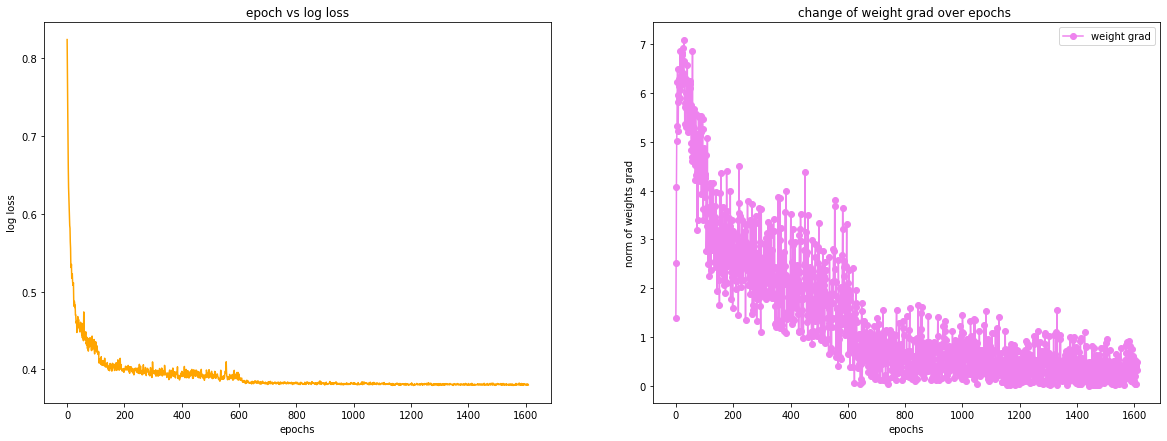

In [ ]:
plot(loss,par)

T-SNE plot on the training dataset: 


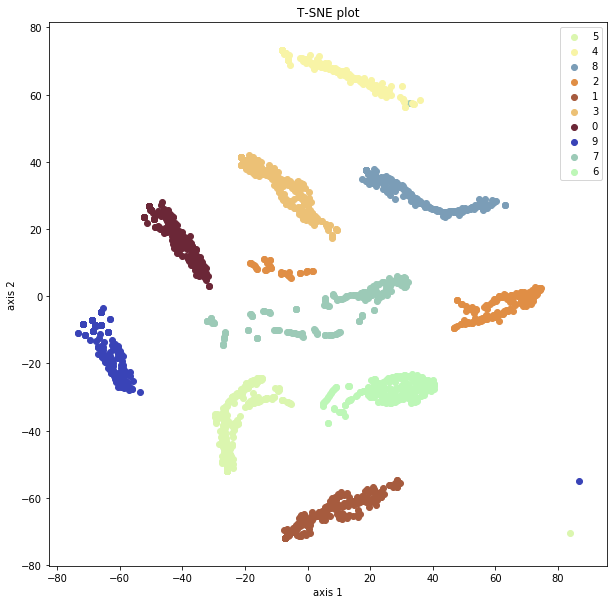

In [ ]:
print("T-SNE plot on the training dataset: ")
tsne_map(traindl,modelcnn)


T-SNE plot on the testing dataset: 


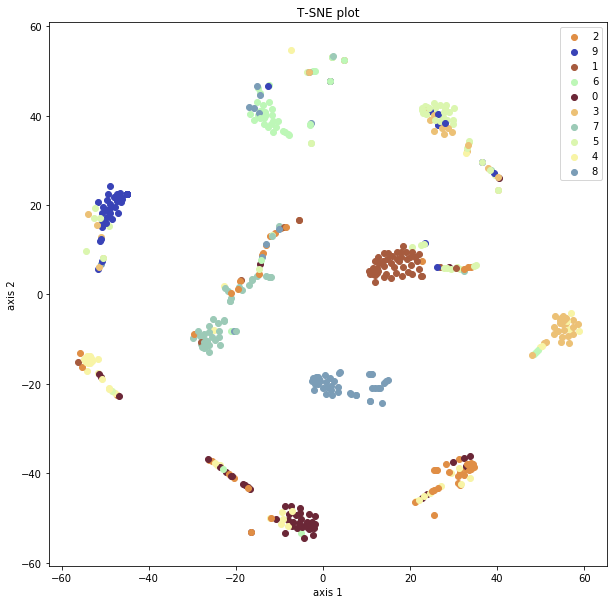

In [ ]:
print("T-SNE plot on the testing dataset: ")
tsne_map(testdl,modelcnn)

In [ ]:
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("validation accuracy:")
get_accuracy(valdl,modelcnn)

Training accuracy:
99.70000386238098 %
validation accuracy:
67.60563254356384 %


0.6760563254356384

In [ ]:
print("Loss on test:")
test(modelcnn,testdl)
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("Test accuracy:")
get_accuracy(testdl,modelcnn)
print("Training f1 score:")
get_f1(traindl,modelcnn)
print("Test f1 score:")
get_f1(testdl,modelcnn)

Loss on test:
1.7513818740844727
Training accuracy:
99.85000491142273 %
Test accuracy:
70.17892599105835 %
Training f1 score:
F1 score: 1.0
Test f1 score:
F1 score: 0.6998012065887451


0.6998012065887451

confusion matrix on the test dataset:


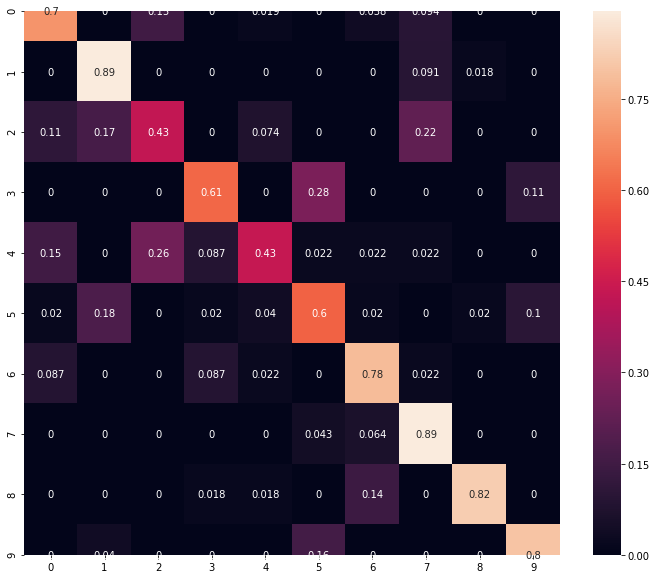

In [ ]:
print("confusion matrix on the test dataset:")
confusionplot(testdl,modelcnn)

In [ ]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl,modelcnn)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.78      0.79      0.79        53
           1       0.73      0.95      0.83        55
           2       0.59      0.48      0.53        54
           3       0.78      0.63      0.70        46
           4       0.70      0.41      0.52        46
           5       0.51      0.54      0.52        50
           6       0.64      0.80      0.71        46
           7       0.66      0.87      0.75        47
           8       0.93      0.75      0.83        56
           9       0.81      0.84      0.82        50

    accuracy                           0.71       503
   macro avg       0.71      0.71      0.70       503
weighted avg       0.72      0.71      0.70       503



### model 2: LSTM

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
class SDRDataset(Dataset):
    def __init__(self, metadata, type):
      self.metadata = metadata[metadata['split'] == type]
    def __len__(self):
      return len(self.metadata)
    def __getitem__(self, idx):
      audio_file = self.metadata.iloc[idx]['identifier']
      digit = self.metadata.iloc[idx]['label']
      signal, sr = librosa.load(os.path.join("./speech_data",audio_file) + ".wav", sr=8000)
      mel_spectrogram = extract_melspectrogram(signal, sr, num_mels=13)
      return torch.tensor(mel_spectrogram.T, dtype=torch.float32), torch.tensor(digit, dtype=torch.long)


In [ ]:
train_dataset = SDRDataset(sdr_df, type = "TRAIN")
traindl2= DataLoader(train_dataset, batch_size=1, shuffle=True)
dev_dataset = SDRDataset(sdr_df, type = "DEV")
valdl2 = DataLoader(dev_dataset, batch_size=1, shuffle=True)
test_dataset = SDRDataset(sdr_df, type = "TEST")
testdl2 = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
class lstm(nn.Module):
     def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,op):
        super(lstm, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim
        self.op = op
        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, input_dim)
        # batch_dim = number of samples per batch
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout=self.op, bidirectional = True)#, nonlinearity='relu')

        # Readout layer
        self.fc1 = nn.Linear(hidden_dim * 2, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 10)
        self.drp = nn.Dropout(self.op)
        self.softmax = nn.LogSoftmax(dim = 1)

     def forward(self, x):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, _ = self.lstm(x, (h0.detach(),c0.detach()) )
        out = self.drp(self.fc1(out[:, -1, :]))
        out = self.drp(self.fc2(out))
        out = self.drp(self.fc3(out))
        out = self.fc4(out)
        return out



     def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01,opti='adam'):
            optidict={'adagrad':torch.optim.Adagrad(self.parameters(), lr=learning_rate),'adam':torch.optim.Adam(self.parameters(),lr=learning_rate),'sgd':torch.optim.SGD(self.parameters(), lr=learning_rate)}
            loss_fn = nn.CrossEntropyLoss()
            optimizer = optidict[opti]
            optimizer.weight_decay = lam #torch.optim.Adam(self.parameters(),lr=learning_rate,weight_decay=lam)
            lossrec=[]
            par_grad=[]
            for epoch in range(epochs):
                tloss=0
                total_grad=0
                for i,(xs,ys) in enumerate(train_loader):
                    xs=xs.to(device)
                    ys=ys.to(device)
                    pred = self.forward(xs.type(torch.FloatTensor).cuda())
                    loss = loss_fn(pred,ys)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    grad=0
                    for p in self.parameters():
                        grad+=torch.norm(p.grad).item()

                    total_grad+=grad
                    tloss+=loss
                lossrec.append((tloss/len(train_loader)).log().item())
                par_grad.append((total_grad/len(train_loader)))
                print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item(),'grad:',(total_grad/len(train_loader)))
            return lossrec,par_grad

In [ ]:
##hyperparameter tuning
la2=0
optim2=''
op2=0
lams = [0.005,0.001,0.0005]
optis = ['adagrad','adam','sgd']
valoss=999
dp=[0.2,0.25,0.3]
for d in dp:
    for l in lams:
            for opt in optis:
                modellstm = lstm(13,300,3,10,d)
                modellstm.to(device)
                modellstm.train(traindl2,epochs = 20, learning_rate=0.001,lam=l,opti=opt)
                if valoss>test(modellstm,valdl2):
                    valoss=test(modellstm,valdl2)
                    print(valoss)
                    la2=l
                    optim2=opt
                    op2=d
print("optimal lambda",la2)
print("optimal optimiser",optim2)
print("optimal dropout",op2)

epoch: 0 loss: 1.886893630027771 grad: 24.39038729888611
epoch: 1 loss: 1.5090981721878052 grad: 41.07620384932973
epoch: 2 loss: 1.3562276363372803 grad: 44.392443139298805
epoch: 3 loss: 1.2639062404632568 grad: 45.47947036465509
epoch: 4 loss: 1.1482408046722412 grad: 50.137349739227766
epoch: 5 loss: 1.0123640298843384 grad: 54.042022064515855
epoch: 6 loss: 0.9259719848632812 grad: 59.89673644216315
epoch: 7 loss: 0.8652892708778381 grad: 60.82858336819418
epoch: 8 loss: 0.7831159830093384 grad: 63.69417482276467
epoch: 9 loss: 0.8378627300262451 grad: 92.0958751000449
epoch: 10 loss: 0.716705858707428 grad: 68.61127998859797
epoch: 11 loss: 0.6638830304145813 grad: 64.57827930551163
epoch: 12 loss: 0.6382091641426086 grad: 65.50871455176578
epoch: 13 loss: 0.5868451595306396 grad: 64.40863492850679
epoch: 14 loss: 0.5530391931533813 grad: 65.74960945257838
epoch: 15 loss: 0.5259122848510742 grad: 63.42939024004396
epoch: 16 loss: 0.4940769076347351 grad: 63.15122554482368
epoch: 

epoch: 16 loss: 0.2741161584854126 grad: 44.90490864710619
epoch: 17 loss: 0.2566972076892853 grad: 43.81845564775765
epoch: 18 loss: 0.2488875389099121 grad: 43.53845657509771
epoch: 19 loss: 0.23621152341365814 grad: 42.806852349341256
2.895931725943638
epoch: 0 loss: 2.2630372047424316 grad: 9.714893534599614
epoch: 1 loss: 2.160337209701538 grad: 10.680916811226735
epoch: 2 loss: 1.938913106918335 grad: 13.851092958130058
epoch: 3 loss: 1.8015302419662476 grad: 16.660034755979105
epoch: 4 loss: 1.471903920173645 grad: 18.54335288195086
epoch: 5 loss: 1.263859510421753 grad: 20.36273496691409
epoch: 6 loss: 1.048929214477539 grad: 20.38813972049688
epoch: 7 loss: 0.9586515426635742 grad: 20.9776068884634
epoch: 8 loss: 0.8033949136734009 grad: 20.55213015892556
epoch: 9 loss: 0.6453853249549866 grad: 18.330342341320122
epoch: 10 loss: 0.5698536038398743 grad: 18.6721711219038
epoch: 11 loss: 0.5267998576164246 grad: 17.67916250957267
epoch: 12 loss: 0.4259639382362366 grad: 14.81084

epoch: 13 loss: 2.3075172901153564 grad: 2.944606220914387
epoch: 14 loss: 2.3082430362701416 grad: 2.775676310799901
epoch: 15 loss: 2.318783760070801 grad: 3.9128976936571447
epoch: 16 loss: 2.1741890907287598 grad: 7.465703673995807
epoch: 17 loss: 2.1821539402008057 grad: 10.36352795276299
epoch: 18 loss: 2.0546836853027344 grad: 14.398540005312046
epoch: 19 loss: 1.9214600324630737 grad: 18.25691593069977
2.521530795040385
epoch: 0 loss: 2.306377649307251 grad: 3.9501442703443463
epoch: 1 loss: 2.3052256107330322 grad: 3.933023402115039
epoch: 2 loss: 2.303947687149048 grad: 3.935228604734584
epoch: 3 loss: 2.3037662506103516 grad: 3.948993161185412
epoch: 4 loss: 2.303488254547119 grad: 3.945362698295503
epoch: 5 loss: 2.30340313911438 grad: 3.938056806573295
epoch: 6 loss: 2.3046650886535645 grad: 3.929891029480903
epoch: 7 loss: 2.303152561187744 grad: 3.930841852853075
epoch: 8 loss: 2.302382230758667 grad: 3.929223407166777
epoch: 9 loss: 2.3032641410827637 grad: 3.9273784710

epoch: 10 loss: 2.302549362182617 grad: 4.100930197086302
epoch: 11 loss: 2.302765130996704 grad: 4.110909150035004
epoch: 12 loss: 2.302828311920166 grad: 4.107038731569017
epoch: 13 loss: 2.3034586906433105 grad: 4.104348873588373
epoch: 14 loss: 2.303367853164673 grad: 4.102570563305519
epoch: 15 loss: 2.3024497032165527 grad: 4.099266061108734
epoch: 16 loss: 2.3031704425811768 grad: 4.097881898522784
epoch: 17 loss: 2.302025318145752 grad: 4.087650120667647
epoch: 18 loss: 2.3026788234710693 grad: 4.092268724644789
epoch: 19 loss: 2.302828311920166 grad: 4.0964767718391375
2.3034831220715097
epoch: 0 loss: 2.112884283065796 grad: 17.46052364313608
epoch: 1 loss: 1.608406662940979 grad: 42.98734911277919
epoch: 2 loss: 1.237836241722107 grad: 60.82165473867754
epoch: 3 loss: 0.9945682287216187 grad: 69.29594862783674
epoch: 4 loss: 0.8483163714408875 grad: 67.34350027177926
epoch: 5 loss: 0.7278653979301453 grad: 67.18651735355841
epoch: 6 loss: 0.6485707759857178 grad: 69.47522427

In [ ]:
la2=0.001
optim2 = 'adagrad'
op2 = 0.3

In [ ]:
modellstm = lstm(13,300,3,10,op2)
modellstm.to(device)
losslstm=[]
parlstm=[]

In [ ]:
total_params = sum(p.numel() for p in modellstm.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 5231460


In [ ]:
loss2,par2=modellstm.train(traindl2,epochs = 200,learning_rate=0.0005,lam=la2,opti=optim2)#100-0.001 #50-0.05 #100-0.01 #300-0.005 #1260 -
losslstm+=loss2
parlstm+=par2
print(test(modellstm,valdl2))

epoch: 0 loss: 0.29006949067115784 grad: 70.65696149330094
epoch: 1 loss: 0.100715272128582 grad: 37.94345529790228
epoch: 2 loss: 0.08786948770284653 grad: 30.114555227613142
epoch: 3 loss: 0.06301166862249374 grad: 22.884288541586983
epoch: 4 loss: 0.05710066109895706 grad: 19.201688987976027
epoch: 5 loss: 0.048478346318006516 grad: 15.353685103537712
epoch: 6 loss: 0.056079283356666565 grad: 24.159134450638557
epoch: 7 loss: 0.042572639882564545 grad: 13.056986032744682
epoch: 8 loss: 0.049222297966480255 grad: 16.85953566353665
epoch: 9 loss: 0.047547709196805954 grad: 15.586507278063625
epoch: 10 loss: 0.041832197457551956 grad: 15.428330295497107
epoch: 11 loss: 0.04456775635480881 grad: 15.049432995212184
epoch: 12 loss: 0.035782650113105774 grad: 11.638522618565055
epoch: 13 loss: 0.04854654148221016 grad: 23.163851177108075
epoch: 14 loss: 0.03994340822100639 grad: 12.766604673261888
epoch: 15 loss: 0.035150520503520966 grad: 11.186397932418574
epoch: 16 loss: 0.0268867500126

epoch: 134 loss: 0.0063383677043020725 grad: 4.1157003002583235
epoch: 135 loss: 0.01395602710545063 grad: 7.743097762263072
epoch: 136 loss: 0.00787433236837387 grad: 4.349870258460618
epoch: 137 loss: 0.007226372137665749 grad: 3.5826369116276
epoch: 138 loss: 0.0083105294033885 grad: 3.8315161836649905
epoch: 139 loss: 0.007267997600138187 grad: 4.225765592945624
epoch: 140 loss: 0.007672966457903385 grad: 3.54402501910101
epoch: 141 loss: 0.0096078896895051 grad: 6.221725997963756
epoch: 142 loss: 0.00738327344879508 grad: 3.632080308446554
epoch: 143 loss: 0.007084590382874012 grad: 4.148666499605571
epoch: 144 loss: 0.006681727711111307 grad: 3.307129414525299
epoch: 145 loss: 0.00866017583757639 grad: 3.9523965103977052
epoch: 146 loss: 0.008524087257683277 grad: 4.1665510044969
epoch: 147 loss: 0.006966063287109137 grad: 3.083062754160648
epoch: 148 loss: 0.00825642328709364 grad: 4.517117838983163
epoch: 149 loss: 0.02045331336557865 grad: 14.54707920203114
epoch: 150 loss: 0.

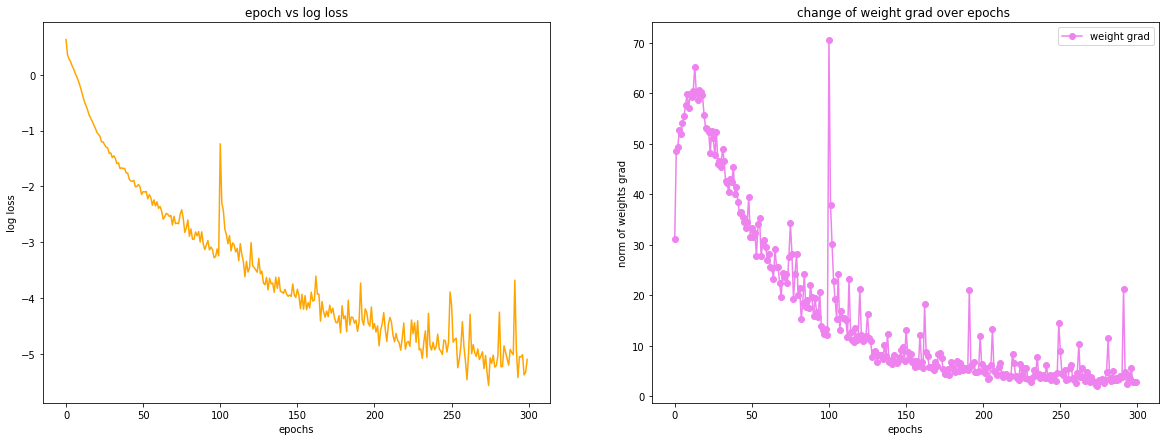

In [ ]:
plot(losslstm,parlstm)

In [ ]:
torch.save(modellstm,'D:/Saarland University/NNTI/project/models/modellstm.pt')

In [ ]:
modellstm=torch.load('D:/Saarland University/NNTI/project/models/modellstm.pt')

T-SNE plot on the testing dataset:


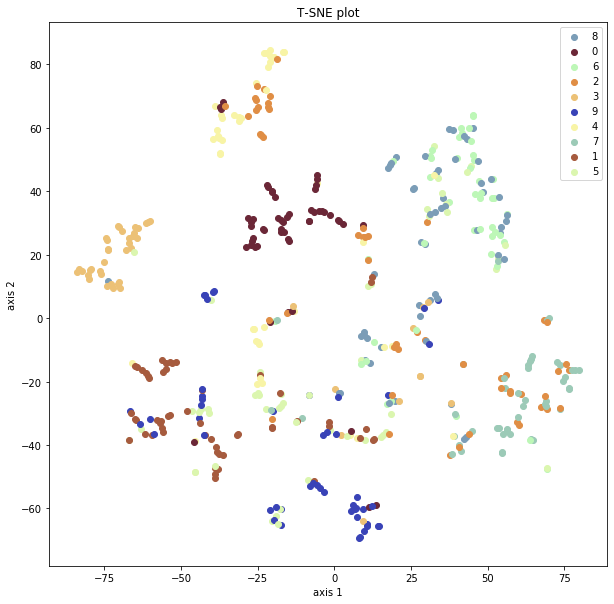

In [ ]:
print("T-SNE plot on the testing dataset:")
tsne_map(testdl2,modellstm)

In [ ]:
print("Training accuracy:")
get_accuracy(traindl2,modellstm)
print("validation accuracy:")
get_accuracy(valdl2,modellstm)

Training accuracy:
99.85000491142273 %
validation accuracy:
51.91146731376648 %


0.5191146731376648

In [ ]:
print("Loss on test:")
test(modellstm,testdl2)
print("Training accuracy:")
get_accuracy(traindl2,modellstm)
print("Test accuracy:")
get_accuracy(testdl2,modellstm)
print("Training f1 score:")
get_f1(traindl2,modellstm)
print("Test f1 score:")
get_f1(testdl2,modellstm)

Loss on test:
4.606705597407299
Training accuracy:
100.0 %
Test accuracy:
52.88270115852356 %
Training f1 score:
F1 score: 0.999
Test f1 score:
F1 score: 0.5248508946322068


1.0

confusion matrix on the test dataset:


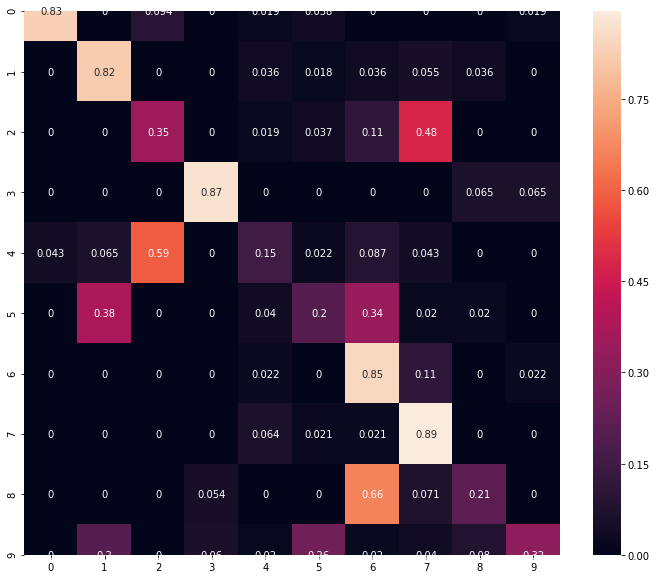

In [ ]:
print("confusion matrix on the test dataset:")
confusionplot(testdl2,modellstm)

In [ ]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl2,modellstm)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        53
           1       0.56      0.82      0.66        55
           2       0.41      0.39      0.40        54
           3       0.88      0.83      0.85        46
           4       0.41      0.15      0.22        46
           5       0.23      0.16      0.19        50
           6       0.36      0.83      0.50        46
           7       0.52      0.91      0.67        47
           8       0.36      0.14      0.21        56
           9       0.79      0.30      0.43        50

    accuracy                           0.53       503
   macro avg       0.55      0.54      0.50       503
weighted avg       0.55      0.53      0.50       503



## Model 3: GRU nodes


In [ ]:
class gru(nn.Module):
     def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,op):
        super(gru, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.op = op
        self.lstm = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True,dropout=self.op, bidirectional = False)#, nonlinearity='relu')

        # Readout layer
        self.fc1 = nn.Linear(hidden_dim, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 10)
        self.drp = nn.Dropout(self.op)

     def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, _ = self.lstm(x, h0.detach() )
        out = self.drp(self.fc1(out[:, -1, :]))
        out = self.drp(self.fc2(out))
        out = self.drp(self.fc3(out))
        out = self.fc4(out)
        return out

     def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01,opti='adam'):
            optidict={'adagrad':torch.optim.Adagrad(self.parameters(), lr=learning_rate),'adam':torch.optim.Adam(self.parameters(),lr=learning_rate),'sgd':torch.optim.SGD(self.parameters(), lr=learning_rate)}
            loss_fn = nn.CrossEntropyLoss()
            optimizer = optidict[opti]
            optimizer.weight_decay = lam #torch.optim.Adam(self.parameters(),lr=learning_rate,weight_decay=lam)
            lossrec=[]
            par_grad=[]
            for epoch in range(epochs):
                tloss=0
                total_grad=0
                for i,(xs,ys) in enumerate(train_loader):
                    xs=xs.to(device)
                    ys=ys.to(device)
                    pred = self.forward(xs.type(torch.FloatTensor).cuda())
                    loss = loss_fn(pred,ys)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    grad=0
                    for p in self.parameters():
                        grad+=torch.norm(p.grad).item()

                    total_grad+=grad
                    tloss+=loss
                lossrec.append((tloss/len(train_loader)).log().item())
                par_grad.append((total_grad/len(train_loader)))
                print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item(),'grad:',(total_grad/len(train_loader)))
            return lossrec,par_grad

In [ ]:
##hyperparameter tuning
la3=0
optim3=''
op3=0
lams = [0.005,0.001,0.0005]
optis = ['adagrad','adam','sgd']
dp=[0.2,0.25,0.3]
valoss=999
for d in dp:
    for l in lams:
            for opt in optis:
                modelgru = gru(13,300,3,10,d)
                modelgru.to(device)
                modelgru.train(traindl2,epochs = 20, learning_rate=0.001,lam=l,opti=opt)
                if valoss>test(modelgru,valdl2):
                    valoss=test(modelgru,valdl2)
                    print(valoss)
                    la3=l
                    optim3=opt
                    op3=d

print("optimal lambda",la3)
print("optimal optimiser",optim3)
print("optimal dropout",op3)

epoch: 0 loss: 1.7856202125549316 grad: 27.84880131639936
epoch: 1 loss: 1.4441555738449097 grad: 40.70689341772627
epoch: 2 loss: 1.2757692337036133 grad: 44.192594334236
epoch: 3 loss: 1.1589734554290771 grad: 46.788749010769415
epoch: 4 loss: 1.0788260698318481 grad: 47.76001072949474
epoch: 5 loss: 1.0011959075927734 grad: 48.77970116989967
epoch: 6 loss: 0.9396648406982422 grad: 48.754435664050284
epoch: 7 loss: 0.8946279883384705 grad: 48.994496397767335
epoch: 8 loss: 0.8373995423316956 grad: 48.86666957046062
epoch: 9 loss: 0.7839179039001465 grad: 48.03751586283819
epoch: 10 loss: 0.7335975766181946 grad: 47.334648642257335
epoch: 11 loss: 0.6897276043891907 grad: 46.77948890905516
epoch: 12 loss: 0.6471343040466309 grad: 46.716038548893486
epoch: 13 loss: 0.6137343049049377 grad: 45.7118731013545
epoch: 14 loss: 0.5598127245903015 grad: 44.216803745553975
epoch: 15 loss: 0.5270741581916809 grad: 44.35322416058572
epoch: 16 loss: 0.5089881420135498 grad: 43.567652926186014
epo

epoch: 16 loss: 0.44288748502731323 grad: 41.85683545819364
epoch: 17 loss: 0.4287336468696594 grad: 42.75775927193831
epoch: 18 loss: 0.42176488041877747 grad: 41.866019275281175
epoch: 19 loss: 0.3894976079463959 grad: 39.973589790429195
1.9225804201951269
epoch: 0 loss: 1.7202337980270386 grad: 31.26142902672579
epoch: 1 loss: 0.788078784942627 grad: 29.220587387325647
epoch: 2 loss: 0.5592096447944641 grad: 24.406382968400916
epoch: 3 loss: 0.4656345248222351 grad: 21.843034961476803
epoch: 4 loss: 0.4299066662788391 grad: 21.921633366724233
epoch: 5 loss: 0.32148241996765137 grad: 18.48417718454964
epoch: 6 loss: 0.3550991415977478 grad: 20.505217564837377
epoch: 7 loss: 0.3338538110256195 grad: 20.3319923993439
epoch: 8 loss: 0.30977392196655273 grad: 19.333349570726337
epoch: 9 loss: 0.31869199872016907 grad: 20.303183399265997
epoch: 10 loss: 0.3380860686302185 grad: 22.55317016446735
epoch: 11 loss: 0.32694700360298157 grad: 23.06039809943519
epoch: 12 loss: 0.3490897715091705

epoch: 12 loss: 0.3957425653934479 grad: 23.618285645697693
epoch: 13 loss: 0.4070846438407898 grad: 25.867609221920368
epoch: 14 loss: 0.3233645558357239 grad: 24.780148674844266
epoch: 15 loss: 0.4531673789024353 grad: 31.102822365422437
epoch: 16 loss: 0.36091241240501404 grad: 23.783936792429543
epoch: 17 loss: 0.36214885115623474 grad: 26.48288272896824
epoch: 18 loss: 0.33529114723205566 grad: 24.4558421965783
epoch: 19 loss: 0.41186246275901794 grad: 29.578749520201175
6.064666621820429
epoch: 0 loss: 2.304198980331421 grad: 5.52162345301127
epoch: 1 loss: 2.3018813133239746 grad: 5.588463360508904
epoch: 2 loss: 2.2982871532440186 grad: 5.735841956838965
epoch: 3 loss: 2.2948684692382812 grad: 5.954993304458447
epoch: 4 loss: 2.2905421257019043 grad: 6.3071763280578885
epoch: 5 loss: 2.281625747680664 grad: 6.909874833306298
epoch: 6 loss: 2.269798755645752 grad: 7.8875790926832705
epoch: 7 loss: 2.2424988746643066 grad: 9.06841341610672
epoch: 8 loss: 2.1909399032592773 grad: 

epoch: 8 loss: 2.016057252883911 grad: 17.499211101057007
epoch: 9 loss: 1.849097490310669 grad: 24.069992690088228
epoch: 10 loss: 1.6659859418869019 grad: 30.814330939451583
epoch: 11 loss: 1.5731362104415894 grad: 36.01873979200283
epoch: 12 loss: 1.4886794090270996 grad: 38.527341115170856
epoch: 13 loss: 1.454525113105774 grad: 40.88369936203584
epoch: 14 loss: 1.3761563301086426 grad: 41.73264808942005
epoch: 15 loss: 1.2883497476577759 grad: 43.170345583171354
epoch: 16 loss: 1.1874593496322632 grad: 45.66879068114143
epoch: 17 loss: 1.1274690628051758 grad: 47.39908451693866
epoch: 18 loss: 1.103464961051941 grad: 48.71026367665333
epoch: 19 loss: 1.0691518783569336 grad: 47.76688225298366
2.435771085440895
epoch: 0 loss: 1.8789472579956055 grad: 27.959486121595372
epoch: 1 loss: 1.3924376964569092 grad: 43.379893261984805
epoch: 2 loss: 1.191699743270874 grad: 48.3197538423863
epoch: 3 loss: 1.0759263038635254 grad: 48.65398221433442
epoch: 4 loss: 0.9933781623840332 grad: 51.

In [ ]:
modelgru = gru(13,300,3,10,op3)
modelgru.to(device)
lossgru=[]
pargru=[]

In [ ]:
total_params = sum(p.numel() for p in modelgru.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 1452960


In [ ]:
loss3,par3=modelgru.train(traindl2,epochs = 200,learning_rate=0.0005,lam=la3,opti=optim3) #100-0.001 #200-0.05 #500-0.005 #150-0.001

lossgru+=loss3
pargru+=par3
print(test(modelgru,valdl2))

epoch: 0 loss: 0.6332976222038269 grad: 133.79882162413293
epoch: 1 loss: 0.18335086107254028 grad: 58.917047492460014
epoch: 2 loss: 0.12488298118114471 grad: 49.44904610343962
epoch: 3 loss: 0.07201915979385376 grad: 37.364247169436105
epoch: 4 loss: 0.06383931636810303 grad: 27.2248356979623
epoch: 5 loss: 0.047340795397758484 grad: 23.00502389903448
epoch: 6 loss: 0.0375472828745842 grad: 16.6797374738456
epoch: 7 loss: 0.028213681653141975 grad: 12.85903928160482
epoch: 8 loss: 0.034599773585796356 grad: 13.366337544754526
epoch: 9 loss: 0.02229805663228035 grad: 9.968232261259969
epoch: 10 loss: 0.02132926695048809 grad: 8.642990513749075
epoch: 11 loss: 0.01735709048807621 grad: 10.448235379025034
epoch: 12 loss: 0.019435623660683632 grad: 10.196479083364949
epoch: 13 loss: 0.0168759785592556 grad: 7.218092347625197
epoch: 14 loss: 0.015266474336385727 grad: 6.749232732104528
epoch: 15 loss: 0.015245450660586357 grad: 5.402481257151225
epoch: 16 loss: 0.016001282259821892 grad: 

epoch: 133 loss: 0.004186295438557863 grad: 1.095335564123306
epoch: 134 loss: 0.006453741807490587 grad: 1.5441812869410396
epoch: 135 loss: 0.004052225966006517 grad: 1.3133600917262747
epoch: 136 loss: 0.004484320059418678 grad: 1.5995006839982935
epoch: 137 loss: 0.005967681761831045 grad: 1.7636549147096534
epoch: 138 loss: 0.004064831882715225 grad: 1.2765995761275657
epoch: 139 loss: 0.00463382201269269 grad: 1.3277035739609113
epoch: 140 loss: 0.0034560326021164656 grad: 1.1594324987771993
epoch: 141 loss: 0.004224528092890978 grad: 1.3424262380094267
epoch: 142 loss: 0.0056365192867815495 grad: 1.5216367649907723
epoch: 143 loss: 0.003946993965655565 grad: 1.3328328609371047
epoch: 144 loss: 0.003444319823756814 grad: 1.0082840847809644
epoch: 145 loss: 0.004156783223152161 grad: 1.2522371270836279
epoch: 146 loss: 0.0038189191836863756 grad: 1.4255046987363302
epoch: 147 loss: 0.004333038814365864 grad: 1.5998452011977937
epoch: 148 loss: 0.0032086982391774654 grad: 1.0142044

In [ ]:
print(test(modelgru,valdl2))

5.831251793309299
5.831251793309299


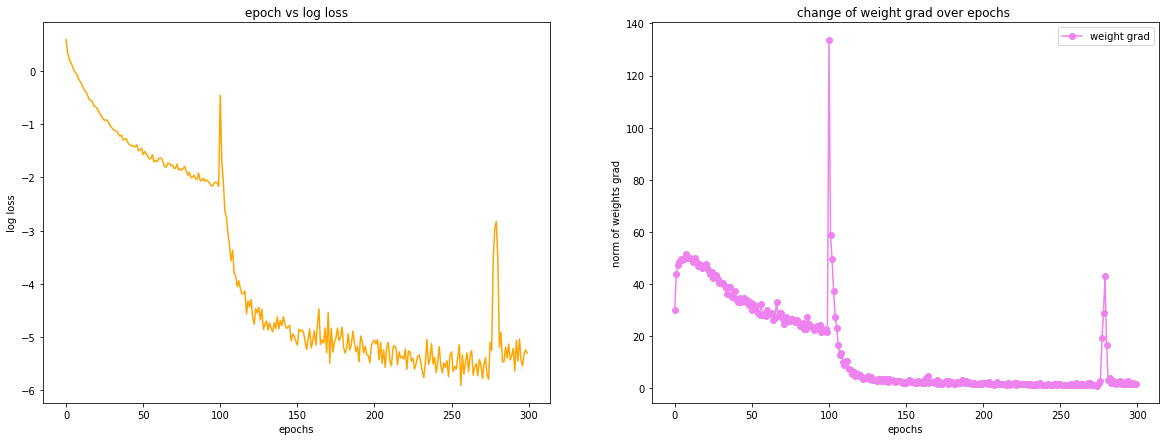

In [ ]:
plot(lossgru,pargru)

In [ ]:
torch.save(modelgru,'D:/Saarland University/NNTI/project/models/modelgru.pt')

In [ ]:
modelgru=torch.load('D:/Saarland University/NNTI/project/models/modellstm.pt')

T-SNE plot on the testing dataset:


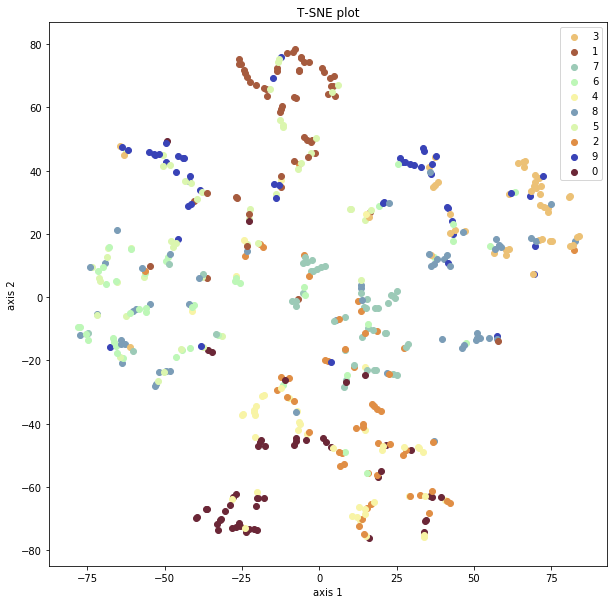

In [ ]:
print("T-SNE plot on the testing dataset:")
tsne_map(testdl2,modelgru)

In [ ]:
print("Training accuracy:")
get_accuracy(traindl2,modelgru)
print("validation accuracy:")
get_accuracy(valdl2,modelgru)

Training accuracy:
99.9500036239624 %
validation accuracy:
53.118711709976196 %


0.531187117099762

In [ ]:
print("Loss on test:")
test(modelgru,testdl2)
print("Training accuracy:")
get_accuracy(traindl2,modelgru)
print("Test accuracy:")
get_accuracy(testdl2,modelgru)
print("Training f1 score:")
get_f1(traindl2,modelgru)
print("Test f1 score:")
get_f1(testdl2,modelgru)

Loss on test:
5.562884283624471
Training accuracy:
99.9000072479248 %
Test accuracy:
55.06957769393921 %
Training f1 score:
F1 score: 0.9995
Test f1 score:
F1 score: 0.5347912524850894


1.0

confusion matrix on the test dataset:


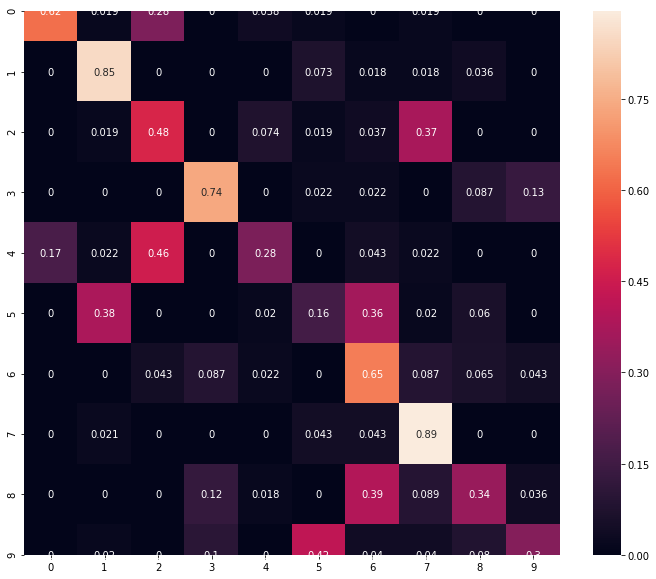

In [ ]:
print("confusion matrix on the test dataset:")
confusionplot(testdl2,modelgru)

In [ ]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl2,modelgru)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.85      0.64      0.73        53
           1       0.66      0.84      0.74        55
           2       0.41      0.52      0.46        54
           3       0.71      0.70      0.70        46
           4       0.58      0.24      0.34        46
           5       0.26      0.20      0.23        50
           6       0.36      0.63      0.46        46
           7       0.55      0.89      0.68        47
           8       0.53      0.34      0.41        56
           9       0.52      0.32      0.40        50

    accuracy                           0.53       503
   macro avg       0.54      0.53      0.51       503
weighted avg       0.54      0.53      0.52       503



## Analysing statistical significance Between models:
we tested the two best performing models for the analysis, namely the CNN based model and the GRu based model

In [ ]:
acc=[]
for i in tqdm(range(503)):
    dummystats=np.zeros((1,melspectrogram.shape[0],maxlength+27))
    datadictstats = {'TEST':dummy}
    labeldictstats = {'TEST':[]}

    for j in range(503):
        idx = randint(0, 502)
        path = sdr_df[sdr_df['split']=='TEST']['file'].iloc[idx]
        label = sdr_df[sdr_df['split']=='TEST']['label'].iloc[idx]
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1)
        datadictstats['TEST']=torch.tensor(np.concatenate((datadictstats['TEST'],data),axis=0))
        labeldictstats['TEST'].append(label)

    test_datastats = datadictstats['TEST'][1:]
    test_ystats = labeldictstats['TEST']

    custom_test_dataset = customDataset(test_datastats, test_ystats)
    custom_test_loader = customDataLoader(custom_test_dataset, batch_size=503)
    testdlstats = custom_test_loader.loader()

    acc.append(get_accuracy(testdlstats,modelcnn))


70.37773132324219 %
72.76341915130615 %
73.95625710487366 %
69.98011469841003 %
75.94432830810547 %
70.37773132324219 %
72.16699719429016 %
72.365802526474 %
67.99204349517822 %
71.76938056945801 %
70.77534198760986 %
67.39562153816223 %
66.40158891677856 %
71.57057523727417 %
68.78727078437805 %
69.1848874092102 %
67.79323816299438 %
67.39562153816223 %
70.17892599105835 %
71.37176394462585 %
69.98011469841003 %
69.7813093662262 %
70.17892599105835 %
66.6003942489624 %
67.99204349517822 %
71.96818590164185 %
68.58846545219421 %
72.76341915130615 %
70.57653665542603 %
73.55864644050598 %
68.78727078437805 %
72.16699719429016 %
70.97415328025818 %
68.58846545219421 %
68.58846545219421 %
71.17295861244202 %
70.97415328025818 %
73.55864644050598 %
69.1848874092102 %
71.76938056945801 %
69.38369274139404 %
68.98608207702637 %
70.77534198760986 %
68.19085478782654 %
68.78727078437805 %
66.79919958114624 %
69.1848874092102 %
68.78727078437805 %
67.39562153816223 %
71.17295861244202 %
69.9801

70.37773132324219 %
68.78727078437805 %
67.59443283081055 %
68.98608207702637 %
69.1848874092102 %
69.98011469841003 %
66.40158891677856 %
71.96818590164185 %
73.35983514785767 %
72.16699719429016 %
69.98011469841003 %
72.16699719429016 %
73.55864644050598 %
69.58250403404236 %
67.39562153816223 %
71.37176394462585 %
69.98011469841003 %
70.97415328025818 %
73.35983514785767 %
69.7813093662262 %
75.5467176437378 %
70.37773132324219 %
74.15506839752197 %
71.96818590164185 %
71.37176394462585 %
69.1848874092102 %
69.38369274139404 %
69.1848874092102 %
69.98011469841003 %
68.98608207702637 %
70.77534198760986 %
69.1848874092102 %
69.7813093662262 %
71.37176394462585 %
72.96222448348999 %
68.58846545219421 %
72.16699719429016 %
70.97415328025818 %
69.7813093662262 %
70.97415328025818 %
71.96818590164185 %
73.55864644050598 %
66.79919958114624 %
66.99801087379456 %
69.7813093662262 %
67.79323816299438 %
73.16102981567383 %
72.16699719429016 %
72.76341915130615 %
71.17295861244202 %
68.588465

In [ ]:
acc2=[]
for i in tqdm(range(503)):
    dummystats2=np.zeros((1,melspectrogram.shape[0],maxlength+27))
    datadictstats2 = {'TEST':dummy}
    labeldictstats2 = {'TEST':[]}
    test_datasetstats2 = SDRDataset(sdr_df, type = "TEST")
    testdl2stats2 = DataLoader(test_datasetstats2, batch_size=1, shuffle=True)##shuffle =True ensures resampling same samples
    acc2.append(get_accuracy(testdl2stats2,modelgru))



  0%|                                                                                          | 0/503 [00:00<?, ?it/s]

54.07554507255554 %




  0%|▏                                                                                 | 1/503 [00:03<26:13,  3.13s/it]

52.485084533691406 %




  0%|▎                                                                                 | 2/503 [00:05<25:27,  3.05s/it]

53.67792844772339 %




  1%|▍                                                                                 | 3/503 [00:08<24:52,  2.99s/it]

53.28031778335571 %




  1%|▋                                                                                 | 4/503 [00:11<24:28,  2.94s/it]

51.68985724449158 %




  1%|▊                                                                                 | 5/503 [00:14<24:15,  2.92s/it]

52.485084533691406 %




  1%|▉                                                                                 | 6/503 [00:17<24:05,  2.91s/it]

52.08747386932373 %




  1%|█▏                                                                                | 7/503 [00:20<24:13,  2.93s/it]

52.68389582633972 %




  2%|█▎                                                                                | 8/503 [00:23<24:07,  2.93s/it]

54.47315573692322 %




  2%|█▍                                                                                | 9/503 [00:26<24:03,  2.92s/it]

53.0815064907074 %




  2%|█▌                                                                               | 10/503 [00:29<24:08,  2.94s/it]

53.47912311553955 %




  2%|█▊                                                                               | 11/503 [00:32<23:56,  2.92s/it]

52.485084533691406 %




  2%|█▉                                                                               | 12/503 [00:35<23:56,  2.93s/it]

52.28627920150757 %




  3%|██                                                                               | 13/503 [00:37<23:51,  2.92s/it]

53.0815064907074 %




  3%|██▎                                                                              | 14/503 [00:40<23:44,  2.91s/it]

52.485084533691406 %




  3%|██▍                                                                              | 15/503 [00:43<23:55,  2.94s/it]

53.67792844772339 %




  3%|██▌                                                                              | 16/503 [00:46<23:57,  2.95s/it]

52.08747386932373 %




  3%|██▋                                                                              | 17/503 [00:49<23:44,  2.93s/it]

51.49105191230774 %




  4%|██▉                                                                              | 18/503 [00:52<23:38,  2.93s/it]

52.28627920150757 %




  4%|███                                                                              | 19/503 [00:55<23:24,  2.90s/it]

53.0815064907074 %




  4%|███▏                                                                             | 20/503 [00:58<23:19,  2.90s/it]

52.88270115852356 %




  4%|███▍                                                                             | 21/503 [01:01<23:13,  2.89s/it]

53.876739740371704 %




  4%|███▌                                                                             | 22/503 [01:04<23:08,  2.89s/it]

52.28627920150757 %




  5%|███▋                                                                             | 23/503 [01:06<23:02,  2.88s/it]

53.28031778335571 %




  5%|███▊                                                                             | 24/503 [01:09<23:01,  2.88s/it]

53.67792844772339 %




  5%|████                                                                             | 25/503 [01:12<22:55,  2.88s/it]

53.47912311553955 %




  5%|████▏                                                                            | 26/503 [01:15<22:56,  2.89s/it]

53.0815064907074 %




  5%|████▎                                                                            | 27/503 [01:18<22:48,  2.87s/it]

54.47315573692322 %




  6%|████▌                                                                            | 28/503 [01:21<22:45,  2.88s/it]

52.28627920150757 %




  6%|████▋                                                                            | 29/503 [01:24<22:41,  2.87s/it]

53.28031778335571 %




  6%|████▊                                                                            | 30/503 [01:27<22:40,  2.88s/it]

53.67792844772339 %




  6%|████▉                                                                            | 31/503 [01:29<22:36,  2.87s/it]

52.28627920150757 %




  6%|█████▏                                                                           | 32/503 [01:32<22:29,  2.87s/it]

52.485084533691406 %




  7%|█████▎                                                                           | 33/503 [01:35<22:24,  2.86s/it]

53.47912311553955 %




  7%|█████▍                                                                           | 34/503 [01:38<22:22,  2.86s/it]

53.28031778335571 %




  7%|█████▋                                                                           | 35/503 [01:41<22:24,  2.87s/it]

52.88270115852356 %




  7%|█████▊                                                                           | 36/503 [01:44<22:23,  2.88s/it]

54.07554507255554 %




  7%|█████▉                                                                           | 37/503 [01:47<22:16,  2.87s/it]

51.68985724449158 %




  8%|██████                                                                           | 38/503 [01:50<22:12,  2.87s/it]

53.47912311553955 %




  8%|██████▎                                                                          | 39/503 [01:52<22:12,  2.87s/it]

52.88270115852356 %




  8%|██████▍                                                                          | 40/503 [01:55<22:10,  2.87s/it]

54.07554507255554 %




  8%|██████▌                                                                          | 41/503 [01:58<22:12,  2.88s/it]

52.68389582633972 %




  8%|██████▊                                                                          | 42/503 [02:01<22:09,  2.88s/it]

52.28627920150757 %




  9%|██████▉                                                                          | 43/503 [02:04<22:08,  2.89s/it]

53.0815064907074 %




  9%|███████                                                                          | 44/503 [02:07<22:08,  2.89s/it]

52.28627920150757 %




  9%|███████▏                                                                         | 45/503 [02:10<22:04,  2.89s/it]

51.88866853713989 %




  9%|███████▍                                                                         | 46/503 [02:13<22:20,  2.93s/it]

52.88270115852356 %




  9%|███████▌                                                                         | 47/503 [02:16<22:24,  2.95s/it]

53.28031778335571 %




 10%|███████▋                                                                         | 48/503 [02:19<22:24,  2.96s/it]

52.485084533691406 %




 10%|███████▉                                                                         | 49/503 [02:22<22:28,  2.97s/it]

52.68389582633972 %




 10%|████████                                                                         | 50/503 [02:25<22:21,  2.96s/it]

52.485084533691406 %




 10%|████████▏                                                                        | 51/503 [02:28<22:20,  2.97s/it]

52.485084533691406 %




 10%|████████▎                                                                        | 52/503 [02:31<22:20,  2.97s/it]

52.68389582633972 %




 11%|████████▌                                                                        | 53/503 [02:34<22:05,  2.94s/it]

51.88866853713989 %




 11%|████████▋                                                                        | 54/503 [02:36<21:58,  2.94s/it]

53.28031778335571 %




 11%|████████▊                                                                        | 55/503 [02:39<22:04,  2.96s/it]

52.68389582633972 %




 11%|█████████                                                                        | 56/503 [02:42<21:54,  2.94s/it]

51.2922465801239 %




 11%|█████████▏                                                                       | 57/503 [02:45<21:43,  2.92s/it]

52.28627920150757 %




 12%|█████████▎                                                                       | 58/503 [02:48<21:42,  2.93s/it]

54.07554507255554 %




 12%|█████████▌                                                                       | 59/503 [02:51<21:35,  2.92s/it]

53.876739740371704 %




 12%|█████████▋                                                                       | 60/503 [02:54<21:34,  2.92s/it]

54.67196702957153 %




 12%|█████████▊                                                                       | 61/503 [02:57<21:26,  2.91s/it]

52.28627920150757 %




 12%|█████████▉                                                                       | 62/503 [03:00<21:29,  2.92s/it]

52.28627920150757 %




 13%|██████████▏                                                                      | 63/503 [03:03<21:27,  2.93s/it]

53.28031778335571 %




 13%|██████████▎                                                                      | 64/503 [03:06<21:20,  2.92s/it]

51.88866853713989 %




 13%|██████████▍                                                                      | 65/503 [03:09<21:14,  2.91s/it]

52.88270115852356 %




 13%|██████████▋                                                                      | 66/503 [03:11<21:06,  2.90s/it]

51.49105191230774 %




 13%|██████████▊                                                                      | 67/503 [03:14<21:04,  2.90s/it]

52.08747386932373 %




 14%|██████████▉                                                                      | 68/503 [03:17<21:18,  2.94s/it]

53.28031778335571 %




 14%|███████████                                                                      | 69/503 [03:20<21:20,  2.95s/it]

52.88270115852356 %




 14%|███████████▎                                                                     | 70/503 [03:23<21:27,  2.97s/it]

53.28031778335571 %




 14%|███████████▍                                                                     | 71/503 [03:26<21:14,  2.95s/it]

53.67792844772339 %




 14%|███████████▌                                                                     | 72/503 [03:29<21:10,  2.95s/it]

51.49105191230774 %




 15%|███████████▊                                                                     | 73/503 [03:32<21:07,  2.95s/it]

52.28627920150757 %




 15%|███████████▉                                                                     | 74/503 [03:35<20:59,  2.94s/it]

53.28031778335571 %




 15%|████████████                                                                     | 75/503 [03:38<20:55,  2.93s/it]

53.47912311553955 %




 15%|████████████▏                                                                    | 76/503 [03:41<20:51,  2.93s/it]

52.68389582633972 %




 15%|████████████▍                                                                    | 77/503 [03:44<20:43,  2.92s/it]

52.88270115852356 %




 16%|████████████▌                                                                    | 78/503 [03:47<20:53,  2.95s/it]

53.28031778335571 %




 16%|████████████▋                                                                    | 79/503 [03:50<20:49,  2.95s/it]

52.68389582633972 %




 16%|████████████▉                                                                    | 80/503 [03:53<20:41,  2.93s/it]

53.47912311553955 %




 16%|█████████████                                                                    | 81/503 [03:56<20:34,  2.93s/it]

52.88270115852356 %




 16%|█████████████▏                                                                   | 82/503 [03:59<20:35,  2.94s/it]

52.485084533691406 %




 17%|█████████████▎                                                                   | 83/503 [04:01<20:28,  2.93s/it]

52.08747386932373 %




 17%|█████████████▌                                                                   | 84/503 [04:04<20:18,  2.91s/it]

52.68389582633972 %




 17%|█████████████▋                                                                   | 85/503 [04:07<20:16,  2.91s/it]

53.28031778335571 %




 17%|█████████████▊                                                                   | 86/503 [04:10<20:15,  2.92s/it]

51.88866853713989 %




 17%|██████████████                                                                   | 87/503 [04:13<20:09,  2.91s/it]

51.68985724449158 %




 17%|██████████████▏                                                                  | 88/503 [04:16<20:04,  2.90s/it]

52.28627920150757 %




 18%|██████████████▎                                                                  | 89/503 [04:19<20:08,  2.92s/it]

52.485084533691406 %




 18%|██████████████▍                                                                  | 90/503 [04:22<20:11,  2.93s/it]

51.2922465801239 %




 18%|██████████████▋                                                                  | 91/503 [04:25<20:03,  2.92s/it]

53.67792844772339 %




 18%|██████████████▊                                                                  | 92/503 [04:28<20:01,  2.92s/it]

51.2922465801239 %




 18%|██████████████▉                                                                  | 93/503 [04:31<20:03,  2.93s/it]

51.68985724449158 %




 19%|███████████████▏                                                                 | 94/503 [04:34<20:05,  2.95s/it]

53.876739740371704 %




 19%|███████████████▎                                                                 | 95/503 [04:37<19:56,  2.93s/it]

53.67792844772339 %




 19%|███████████████▍                                                                 | 96/503 [04:40<20:01,  2.95s/it]

52.485084533691406 %




 19%|███████████████▌                                                                 | 97/503 [04:42<19:56,  2.95s/it]

53.0815064907074 %




 19%|███████████████▊                                                                 | 98/503 [04:45<19:45,  2.93s/it]

52.88270115852356 %




 20%|███████████████▉                                                                 | 99/503 [04:48<20:02,  2.98s/it]

53.876739740371704 %




 20%|███████████████▉                                                                | 100/503 [04:51<20:00,  2.98s/it]

52.08747386932373 %




 20%|████████████████                                                                | 101/503 [04:54<19:50,  2.96s/it]

52.68389582633972 %




 20%|████████████████▏                                                               | 102/503 [04:57<19:40,  2.94s/it]

53.0815064907074 %




 20%|████████████████▍                                                               | 103/503 [05:00<19:27,  2.92s/it]

51.49105191230774 %




 21%|████████████████▌                                                               | 104/503 [05:03<19:26,  2.92s/it]

51.49105191230774 %




 21%|████████████████▋                                                               | 105/503 [05:06<19:17,  2.91s/it]

51.88866853713989 %




 21%|████████████████▊                                                               | 106/503 [05:09<19:26,  2.94s/it]

52.68389582633972 %




 21%|█████████████████                                                               | 107/503 [05:12<19:24,  2.94s/it]

52.08747386932373 %




 21%|█████████████████▏                                                              | 108/503 [05:15<19:32,  2.97s/it]

52.08747386932373 %




 22%|█████████████████▎                                                              | 109/503 [05:18<19:26,  2.96s/it]

52.08747386932373 %




 22%|█████████████████▍                                                              | 110/503 [05:21<19:20,  2.95s/it]

52.485084533691406 %




 22%|█████████████████▋                                                              | 111/503 [05:24<19:13,  2.94s/it]

53.876739740371704 %




 22%|█████████████████▊                                                              | 112/503 [05:27<19:12,  2.95s/it]

52.88270115852356 %




 22%|█████████████████▉                                                              | 113/503 [05:30<19:18,  2.97s/it]

53.47912311553955 %




 23%|██████████████████▏                                                             | 114/503 [05:33<19:08,  2.95s/it]

53.28031778335571 %




 23%|██████████████████▎                                                             | 115/503 [05:35<18:57,  2.93s/it]

52.485084533691406 %




 23%|██████████████████▍                                                             | 116/503 [05:38<18:53,  2.93s/it]

52.08747386932373 %




 23%|██████████████████▌                                                             | 117/503 [05:41<19:06,  2.97s/it]

52.08747386932373 %




 23%|██████████████████▊                                                             | 118/503 [05:44<19:11,  2.99s/it]

51.88866853713989 %




 24%|██████████████████▉                                                             | 119/503 [05:48<19:22,  3.03s/it]

52.08747386932373 %




 24%|███████████████████                                                             | 120/503 [05:51<19:20,  3.03s/it]

52.88270115852356 %




 24%|███████████████████▏                                                            | 121/503 [05:54<19:13,  3.02s/it]

52.28627920150757 %




 24%|███████████████████▍                                                            | 122/503 [05:57<19:13,  3.03s/it]

53.47912311553955 %




 24%|███████████████████▌                                                            | 123/503 [06:00<19:05,  3.01s/it]

52.68389582633972 %




 25%|███████████████████▋                                                            | 124/503 [06:03<19:05,  3.02s/it]

52.08747386932373 %




 25%|███████████████████▉                                                            | 125/503 [06:06<18:59,  3.01s/it]

52.88270115852356 %




 25%|████████████████████                                                            | 126/503 [06:09<19:07,  3.04s/it]

52.08747386932373 %




 25%|████████████████████▏                                                           | 127/503 [06:12<18:50,  3.01s/it]

54.27435040473938 %




 25%|████████████████████▎                                                           | 128/503 [06:15<18:45,  3.00s/it]

52.28627920150757 %




 26%|████████████████████▌                                                           | 129/503 [06:18<18:41,  3.00s/it]

52.68389582633972 %




 26%|████████████████████▋                                                           | 130/503 [06:21<18:37,  3.00s/it]

52.68389582633972 %




 26%|████████████████████▊                                                           | 131/503 [06:24<18:28,  2.98s/it]

53.876739740371704 %




 26%|████████████████████▉                                                           | 132/503 [06:27<18:19,  2.96s/it]

51.49105191230774 %




 26%|█████████████████████▏                                                          | 133/503 [06:30<18:14,  2.96s/it]

53.0815064907074 %




 27%|█████████████████████▎                                                          | 134/503 [06:33<18:26,  3.00s/it]

52.68389582633972 %




 27%|█████████████████████▍                                                          | 135/503 [06:36<18:23,  3.00s/it]

53.0815064907074 %




 27%|█████████████████████▋                                                          | 136/503 [06:39<18:25,  3.01s/it]

53.28031778335571 %




 27%|█████████████████████▊                                                          | 137/503 [06:42<18:19,  3.00s/it]

52.68389582633972 %




 27%|█████████████████████▉                                                          | 138/503 [06:45<18:08,  2.98s/it]

53.47912311553955 %




 28%|██████████████████████                                                          | 139/503 [06:48<18:01,  2.97s/it]

53.28031778335571 %




 28%|██████████████████████▎                                                         | 140/503 [06:51<18:05,  2.99s/it]

51.49105191230774 %




 28%|██████████████████████▍                                                         | 141/503 [06:53<17:53,  2.96s/it]

52.485084533691406 %




 28%|██████████████████████▌                                                         | 142/503 [06:56<17:54,  2.98s/it]

53.0815064907074 %




 28%|██████████████████████▋                                                         | 143/503 [07:00<18:04,  3.01s/it]

52.88270115852356 %




 29%|██████████████████████▉                                                         | 144/503 [07:03<18:00,  3.01s/it]

50.69582462310791 %




 29%|███████████████████████                                                         | 145/503 [07:05<17:44,  2.97s/it]

52.28627920150757 %




 29%|███████████████████████▏                                                        | 146/503 [07:08<17:36,  2.96s/it]

54.07554507255554 %




 29%|███████████████████████▍                                                        | 147/503 [07:11<17:30,  2.95s/it]

51.49105191230774 %




 29%|███████████████████████▌                                                        | 148/503 [07:14<17:26,  2.95s/it]

53.67792844772339 %




 30%|███████████████████████▋                                                        | 149/503 [07:17<17:22,  2.94s/it]

53.47912311553955 %




 30%|███████████████████████▊                                                        | 150/503 [07:20<17:20,  2.95s/it]

51.88866853713989 %




 30%|████████████████████████                                                        | 151/503 [07:23<17:14,  2.94s/it]

53.0815064907074 %




 30%|████████████████████████▏                                                       | 152/503 [07:26<17:20,  2.96s/it]

53.876739740371704 %




 30%|████████████████████████▎                                                       | 153/503 [07:29<17:14,  2.96s/it]

52.485084533691406 %




 31%|████████████████████████▍                                                       | 154/503 [07:32<17:06,  2.94s/it]

51.49105191230774 %




 31%|████████████████████████▋                                                       | 155/503 [07:35<17:09,  2.96s/it]

53.876739740371704 %




 31%|████████████████████████▊                                                       | 156/503 [07:38<17:06,  2.96s/it]

51.49105191230774 %




 31%|████████████████████████▉                                                       | 157/503 [07:41<17:01,  2.95s/it]

52.88270115852356 %




 31%|█████████████████████████▏                                                      | 158/503 [07:44<16:57,  2.95s/it]

52.28627920150757 %




 32%|█████████████████████████▎                                                      | 159/503 [07:47<16:48,  2.93s/it]

51.88866853713989 %




 32%|█████████████████████████▍                                                      | 160/503 [07:50<16:45,  2.93s/it]

52.28627920150757 %




 32%|█████████████████████████▌                                                      | 161/503 [07:52<16:40,  2.93s/it]

53.0815064907074 %




 32%|█████████████████████████▊                                                      | 162/503 [07:55<16:37,  2.93s/it]

52.08747386932373 %




 32%|█████████████████████████▉                                                      | 163/503 [07:58<16:32,  2.92s/it]

53.0815064907074 %




 33%|██████████████████████████                                                      | 164/503 [08:01<16:29,  2.92s/it]

52.485084533691406 %




 33%|██████████████████████████▏                                                     | 165/503 [08:04<16:31,  2.93s/it]

53.0815064907074 %




 33%|██████████████████████████▍                                                     | 166/503 [08:07<16:25,  2.93s/it]

51.68985724449158 %




 33%|██████████████████████████▌                                                     | 167/503 [08:10<16:24,  2.93s/it]

53.47912311553955 %




 33%|██████████████████████████▋                                                     | 168/503 [08:13<16:28,  2.95s/it]

52.08747386932373 %




 34%|██████████████████████████▉                                                     | 169/503 [08:16<16:30,  2.97s/it]

53.47912311553955 %




 34%|███████████████████████████                                                     | 170/503 [08:19<16:26,  2.96s/it]

52.08747386932373 %




 34%|███████████████████████████▏                                                    | 171/503 [08:22<16:37,  3.00s/it]

53.28031778335571 %




 34%|███████████████████████████▎                                                    | 172/503 [08:25<16:26,  2.98s/it]

53.28031778335571 %




 34%|███████████████████████████▌                                                    | 173/503 [08:28<16:34,  3.01s/it]

54.07554507255554 %




 35%|███████████████████████████▋                                                    | 174/503 [08:31<16:34,  3.02s/it]

51.68985724449158 %




 35%|███████████████████████████▊                                                    | 175/503 [08:34<16:25,  3.00s/it]

53.28031778335571 %




 35%|███████████████████████████▉                                                    | 176/503 [08:37<16:20,  3.00s/it]

52.28627920150757 %




 35%|████████████████████████████▏                                                   | 177/503 [08:40<16:13,  2.99s/it]

52.485084533691406 %




 35%|████████████████████████████▎                                                   | 178/503 [08:43<16:03,  2.97s/it]

51.88866853713989 %




 36%|████████████████████████████▍                                                   | 179/503 [08:46<15:57,  2.96s/it]

54.27435040473938 %




 36%|████████████████████████████▋                                                   | 180/503 [08:49<15:52,  2.95s/it]

53.67792844772339 %




 36%|████████████████████████████▊                                                   | 181/503 [08:52<15:46,  2.94s/it]

53.28031778335571 %




 36%|████████████████████████████▉                                                   | 182/503 [08:55<15:48,  2.95s/it]

52.88270115852356 %




 36%|█████████████████████████████                                                   | 183/503 [08:58<15:42,  2.94s/it]

53.67792844772339 %




 37%|█████████████████████████████▎                                                  | 184/503 [09:01<15:40,  2.95s/it]

52.68389582633972 %




 37%|█████████████████████████████▍                                                  | 185/503 [09:04<15:34,  2.94s/it]

52.485084533691406 %




 37%|█████████████████████████████▌                                                  | 186/503 [09:06<15:30,  2.93s/it]

51.88866853713989 %




 37%|█████████████████████████████▋                                                  | 187/503 [09:09<15:25,  2.93s/it]

50.69582462310791 %




 37%|█████████████████████████████▉                                                  | 188/503 [09:12<15:24,  2.93s/it]

51.88866853713989 %




 38%|██████████████████████████████                                                  | 189/503 [09:15<15:20,  2.93s/it]

50.497013330459595 %




 38%|██████████████████████████████▏                                                 | 190/503 [09:18<15:22,  2.95s/it]

51.49105191230774 %




 38%|██████████████████████████████▍                                                 | 191/503 [09:21<15:17,  2.94s/it]

51.88866853713989 %




 38%|██████████████████████████████▌                                                 | 192/503 [09:24<15:16,  2.95s/it]

52.68389582633972 %




 38%|██████████████████████████████▋                                                 | 193/503 [09:27<15:09,  2.93s/it]

54.27435040473938 %




 39%|██████████████████████████████▊                                                 | 194/503 [09:30<15:08,  2.94s/it]

54.07554507255554 %




 39%|███████████████████████████████                                                 | 195/503 [09:33<15:01,  2.93s/it]

52.08747386932373 %




 39%|███████████████████████████████▏                                                | 196/503 [09:36<14:57,  2.92s/it]

52.68389582633972 %




 39%|███████████████████████████████▎                                                | 197/503 [09:39<14:56,  2.93s/it]

53.0815064907074 %




 39%|███████████████████████████████▍                                                | 198/503 [09:42<14:53,  2.93s/it]

52.68389582633972 %




 40%|███████████████████████████████▋                                                | 199/503 [09:45<14:53,  2.94s/it]

52.08747386932373 %




 40%|███████████████████████████████▊                                                | 200/503 [09:48<14:49,  2.94s/it]

53.47912311553955 %




 40%|███████████████████████████████▉                                                | 201/503 [09:50<14:44,  2.93s/it]

52.88270115852356 %




 40%|████████████████████████████████▏                                               | 202/503 [09:53<14:39,  2.92s/it]

51.68985724449158 %




 40%|████████████████████████████████▎                                               | 203/503 [09:56<14:33,  2.91s/it]

52.68389582633972 %




 41%|████████████████████████████████▍                                               | 204/503 [09:59<14:35,  2.93s/it]

53.0815064907074 %




 41%|████████████████████████████████▌                                               | 205/503 [10:02<14:28,  2.91s/it]

52.08747386932373 %




 41%|████████████████████████████████▊                                               | 206/503 [10:05<14:27,  2.92s/it]

52.08747386932373 %




 41%|████████████████████████████████▉                                               | 207/503 [10:08<14:22,  2.91s/it]

52.28627920150757 %




 41%|█████████████████████████████████                                               | 208/503 [10:11<14:18,  2.91s/it]

52.88270115852356 %




 42%|█████████████████████████████████▏                                              | 209/503 [10:14<14:19,  2.92s/it]

54.07554507255554 %




 42%|█████████████████████████████████▍                                              | 210/503 [10:17<14:17,  2.93s/it]

52.88270115852356 %




 42%|█████████████████████████████████▌                                              | 211/503 [10:20<14:11,  2.91s/it]

52.68389582633972 %




 42%|█████████████████████████████████▋                                              | 212/503 [10:23<14:06,  2.91s/it]

51.88866853713989 %




 42%|█████████████████████████████████▉                                              | 213/503 [10:25<14:02,  2.91s/it]

52.68389582633972 %




 43%|██████████████████████████████████                                              | 214/503 [10:28<14:01,  2.91s/it]

53.47912311553955 %




 43%|██████████████████████████████████▏                                             | 215/503 [10:31<13:56,  2.90s/it]

53.67792844772339 %




 43%|██████████████████████████████████▎                                             | 216/503 [10:34<14:04,  2.94s/it]

52.88270115852356 %




 43%|██████████████████████████████████▌                                             | 217/503 [10:37<14:08,  2.97s/it]

52.08747386932373 %




 43%|██████████████████████████████████▋                                             | 218/503 [10:40<14:05,  2.97s/it]

51.2922465801239 %




 44%|██████████████████████████████████▊                                             | 219/503 [10:43<13:59,  2.96s/it]

52.68389582633972 %




 44%|██████████████████████████████████▉                                             | 220/503 [10:46<13:53,  2.95s/it]

52.08747386932373 %




 44%|███████████████████████████████████▏                                            | 221/503 [10:49<13:50,  2.94s/it]

52.68389582633972 %




 44%|███████████████████████████████████▎                                            | 222/503 [10:52<13:46,  2.94s/it]

52.28627920150757 %




 44%|███████████████████████████████████▍                                            | 223/503 [10:55<13:49,  2.96s/it]

53.67792844772339 %




 45%|███████████████████████████████████▋                                            | 224/503 [10:58<13:52,  2.98s/it]

51.2922465801239 %




 45%|███████████████████████████████████▊                                            | 225/503 [11:01<14:00,  3.02s/it]

52.28627920150757 %




 45%|███████████████████████████████████▉                                            | 226/503 [11:04<13:57,  3.02s/it]

53.0815064907074 %




 45%|████████████████████████████████████                                            | 227/503 [11:07<13:55,  3.03s/it]

52.28627920150757 %




 45%|████████████████████████████████████▎                                           | 228/503 [11:10<13:52,  3.03s/it]

51.68985724449158 %




 46%|████████████████████████████████████▍                                           | 229/503 [11:13<13:47,  3.02s/it]

52.88270115852356 %




 46%|████████████████████████████████████▌                                           | 230/503 [11:16<13:42,  3.01s/it]

53.876739740371704 %




 46%|████████████████████████████████████▋                                           | 231/503 [11:19<13:39,  3.01s/it]

52.08747386932373 %




 46%|████████████████████████████████████▉                                           | 232/503 [11:22<13:37,  3.02s/it]

51.88866853713989 %




 46%|█████████████████████████████████████                                           | 233/503 [11:25<13:29,  3.00s/it]

53.0815064907074 %




 47%|█████████████████████████████████████▏                                          | 234/503 [11:28<13:27,  3.00s/it]

52.485084533691406 %




 47%|█████████████████████████████████████▍                                          | 235/503 [11:31<13:27,  3.01s/it]

52.485084533691406 %




 47%|█████████████████████████████████████▌                                          | 236/503 [11:34<13:26,  3.02s/it]

52.485084533691406 %




 47%|█████████████████████████████████████▋                                          | 237/503 [11:37<13:13,  2.98s/it]

53.67792844772339 %




 47%|█████████████████████████████████████▊                                          | 238/503 [11:40<13:07,  2.97s/it]

51.68985724449158 %




 48%|██████████████████████████████████████                                          | 239/503 [11:43<12:59,  2.95s/it]

51.68985724449158 %




 48%|██████████████████████████████████████▏                                         | 240/503 [11:46<12:56,  2.95s/it]

51.49105191230774 %




 48%|██████████████████████████████████████▎                                         | 241/503 [11:49<12:57,  2.97s/it]

53.876739740371704 %




 48%|██████████████████████████████████████▍                                         | 242/503 [11:52<12:49,  2.95s/it]

52.485084533691406 %




 48%|██████████████████████████████████████▋                                         | 243/503 [11:55<12:43,  2.94s/it]

54.07554507255554 %




 49%|██████████████████████████████████████▊                                         | 244/503 [11:58<12:40,  2.94s/it]

53.47912311553955 %




 49%|██████████████████████████████████████▉                                         | 245/503 [12:01<12:39,  2.94s/it]

50.89462995529175 %




 49%|███████████████████████████████████████▏                                        | 246/503 [12:04<12:34,  2.94s/it]

51.88866853713989 %




 49%|███████████████████████████████████████▎                                        | 247/503 [12:07<12:28,  2.92s/it]

52.08747386932373 %




 49%|███████████████████████████████████████▍                                        | 248/503 [12:09<12:27,  2.93s/it]

52.28627920150757 %




 50%|███████████████████████████████████████▌                                        | 249/503 [12:12<12:27,  2.94s/it]

53.28031778335571 %




 50%|███████████████████████████████████████▊                                        | 250/503 [12:15<12:22,  2.94s/it]

52.28627920150757 %




 50%|███████████████████████████████████████▉                                        | 251/503 [12:18<12:16,  2.92s/it]

52.88270115852356 %




 50%|████████████████████████████████████████                                        | 252/503 [12:21<12:16,  2.93s/it]

53.28031778335571 %




 50%|████████████████████████████████████████▏                                       | 253/503 [12:24<12:10,  2.92s/it]

53.67792844772339 %




 50%|████████████████████████████████████████▍                                       | 254/503 [12:27<12:07,  2.92s/it]

53.28031778335571 %




 51%|████████████████████████████████████████▌                                       | 255/503 [12:30<12:09,  2.94s/it]

53.876739740371704 %




 51%|████████████████████████████████████████▋                                       | 256/503 [12:33<12:02,  2.92s/it]

53.47912311553955 %




 51%|████████████████████████████████████████▊                                       | 257/503 [12:36<11:57,  2.91s/it]

52.88270115852356 %




 51%|█████████████████████████████████████████                                       | 258/503 [12:39<11:52,  2.91s/it]

52.68389582633972 %




 51%|█████████████████████████████████████████▏                                      | 259/503 [12:42<11:54,  2.93s/it]

51.68985724449158 %




 52%|█████████████████████████████████████████▎                                      | 260/503 [12:45<11:52,  2.93s/it]

52.68389582633972 %




 52%|█████████████████████████████████████████▌                                      | 261/503 [12:48<11:48,  2.93s/it]

51.49105191230774 %




 52%|█████████████████████████████████████████▋                                      | 262/503 [12:50<11:42,  2.92s/it]

53.47912311553955 %




 52%|█████████████████████████████████████████▊                                      | 263/503 [12:53<11:37,  2.91s/it]

52.08747386932373 %




 52%|█████████████████████████████████████████▉                                      | 264/503 [12:56<11:34,  2.91s/it]

52.68389582633972 %




 53%|██████████████████████████████████████████▏                                     | 265/503 [12:59<11:35,  2.92s/it]

52.68389582633972 %




 53%|██████████████████████████████████████████▎                                     | 266/503 [13:02<11:33,  2.93s/it]

52.485084533691406 %




 53%|██████████████████████████████████████████▍                                     | 267/503 [13:05<11:34,  2.94s/it]

53.47912311553955 %




 53%|██████████████████████████████████████████▌                                     | 268/503 [13:08<11:29,  2.93s/it]

52.08747386932373 %




 53%|██████████████████████████████████████████▊                                     | 269/503 [13:11<11:25,  2.93s/it]

53.67792844772339 %




 54%|██████████████████████████████████████████▉                                     | 270/503 [13:14<11:21,  2.93s/it]

52.08747386932373 %




 54%|███████████████████████████████████████████                                     | 271/503 [13:17<11:20,  2.93s/it]

54.07554507255554 %




 54%|███████████████████████████████████████████▎                                    | 272/503 [13:20<11:14,  2.92s/it]

51.2922465801239 %




 54%|███████████████████████████████████████████▍                                    | 273/503 [13:23<11:11,  2.92s/it]

53.67792844772339 %




 54%|███████████████████████████████████████████▌                                    | 274/503 [13:26<11:11,  2.93s/it]

52.68389582633972 %




 55%|███████████████████████████████████████████▋                                    | 275/503 [13:29<11:08,  2.93s/it]

53.28031778335571 %




 55%|███████████████████████████████████████████▉                                    | 276/503 [13:31<11:05,  2.93s/it]

53.0815064907074 %




 55%|████████████████████████████████████████████                                    | 277/503 [13:34<11:00,  2.92s/it]

53.0815064907074 %




 55%|████████████████████████████████████████████▏                                   | 278/503 [13:37<10:55,  2.91s/it]

52.88270115852356 %




 55%|████████████████████████████████████████████▎                                   | 279/503 [13:40<10:53,  2.92s/it]

53.0815064907074 %




 56%|████████████████████████████████████████████▌                                   | 280/503 [13:43<10:52,  2.93s/it]

53.67792844772339 %




 56%|████████████████████████████████████████████▋                                   | 281/503 [13:46<10:47,  2.92s/it]

52.68389582633972 %




 56%|████████████████████████████████████████████▊                                   | 282/503 [13:49<10:44,  2.92s/it]

52.28627920150757 %




 56%|█████████████████████████████████████████████                                   | 283/503 [13:52<10:41,  2.92s/it]

53.0815064907074 %




 56%|█████████████████████████████████████████████▏                                  | 284/503 [13:55<10:39,  2.92s/it]

53.47912311553955 %




 57%|█████████████████████████████████████████████▎                                  | 285/503 [13:58<10:36,  2.92s/it]

52.88270115852356 %




 57%|█████████████████████████████████████████████▍                                  | 286/503 [14:01<10:37,  2.94s/it]

53.67792844772339 %




 57%|█████████████████████████████████████████████▋                                  | 287/503 [14:04<10:32,  2.93s/it]

51.093435287475586 %




 57%|█████████████████████████████████████████████▊                                  | 288/503 [14:07<10:30,  2.93s/it]

53.47912311553955 %




 57%|█████████████████████████████████████████████▉                                  | 289/503 [14:09<10:26,  2.93s/it]

52.485084533691406 %




 58%|██████████████████████████████████████████████                                  | 290/503 [14:12<10:23,  2.93s/it]

51.88866853713989 %




 58%|██████████████████████████████████████████████▎                                 | 291/503 [14:15<10:21,  2.93s/it]

52.485084533691406 %




 58%|██████████████████████████████████████████████▍                                 | 292/503 [14:18<10:15,  2.92s/it]

53.876739740371704 %




 58%|██████████████████████████████████████████████▌                                 | 293/503 [14:21<10:13,  2.92s/it]

51.88866853713989 %




 58%|██████████████████████████████████████████████▊                                 | 294/503 [14:24<10:10,  2.92s/it]

52.28627920150757 %




 59%|██████████████████████████████████████████████▉                                 | 295/503 [14:27<10:06,  2.92s/it]

52.28627920150757 %




 59%|███████████████████████████████████████████████                                 | 296/503 [14:30<10:04,  2.92s/it]

53.0815064907074 %




 59%|███████████████████████████████████████████████▏                                | 297/503 [14:33<10:04,  2.93s/it]

51.68985724449158 %




 59%|███████████████████████████████████████████████▍                                | 298/503 [14:36<10:02,  2.94s/it]

52.88270115852356 %




 59%|███████████████████████████████████████████████▌                                | 299/503 [14:39<09:59,  2.94s/it]

53.0815064907074 %




 60%|███████████████████████████████████████████████▋                                | 300/503 [14:42<09:57,  2.94s/it]

53.0815064907074 %




 60%|███████████████████████████████████████████████▊                                | 301/503 [14:45<09:53,  2.94s/it]

52.485084533691406 %




 60%|████████████████████████████████████████████████                                | 302/503 [14:48<09:51,  2.94s/it]

53.28031778335571 %




 60%|████████████████████████████████████████████████▏                               | 303/503 [14:50<09:46,  2.93s/it]

52.68389582633972 %




 60%|████████████████████████████████████████████████▎                               | 304/503 [14:53<09:43,  2.93s/it]

53.47912311553955 %




 61%|████████████████████████████████████████████████▌                               | 305/503 [14:56<09:40,  2.93s/it]

52.68389582633972 %




 61%|████████████████████████████████████████████████▋                               | 306/503 [14:59<09:36,  2.93s/it]

51.2922465801239 %




 61%|████████████████████████████████████████████████▊                               | 307/503 [15:02<09:33,  2.93s/it]

52.68389582633972 %




 61%|████████████████████████████████████████████████▉                               | 308/503 [15:05<09:28,  2.92s/it]

51.88866853713989 %




 61%|█████████████████████████████████████████████████▏                              | 309/503 [15:08<09:27,  2.93s/it]

52.88270115852356 %




 62%|█████████████████████████████████████████████████▎                              | 310/503 [15:11<09:22,  2.92s/it]

54.27435040473938 %




 62%|█████████████████████████████████████████████████▍                              | 311/503 [15:14<09:21,  2.92s/it]

52.485084533691406 %




 62%|█████████████████████████████████████████████████▌                              | 312/503 [15:17<09:17,  2.92s/it]

52.485084533691406 %




 62%|█████████████████████████████████████████████████▊                              | 313/503 [15:20<09:17,  2.93s/it]

53.28031778335571 %




 62%|█████████████████████████████████████████████████▉                              | 314/503 [15:23<09:14,  2.94s/it]

52.88270115852356 %




 63%|██████████████████████████████████████████████████                              | 315/503 [15:26<09:11,  2.93s/it]

53.0815064907074 %




 63%|██████████████████████████████████████████████████▎                             | 316/503 [15:29<09:09,  2.94s/it]

52.485084533691406 %




 63%|██████████████████████████████████████████████████▍                             | 317/503 [15:31<09:03,  2.92s/it]

51.68985724449158 %




 63%|██████████████████████████████████████████████████▌                             | 318/503 [15:34<09:01,  2.93s/it]

53.47912311553955 %




 63%|██████████████████████████████████████████████████▋                             | 319/503 [15:37<08:58,  2.93s/it]

52.08747386932373 %




 64%|██████████████████████████████████████████████████▉                             | 320/503 [15:40<08:56,  2.93s/it]

52.88270115852356 %




 64%|███████████████████████████████████████████████████                             | 321/503 [15:43<08:54,  2.93s/it]

51.68985724449158 %




 64%|███████████████████████████████████████████████████▏                            | 322/503 [15:46<08:50,  2.93s/it]

52.08747386932373 %




 64%|███████████████████████████████████████████████████▎                            | 323/503 [15:49<08:51,  2.96s/it]

53.0815064907074 %




 64%|███████████████████████████████████████████████████▌                            | 324/503 [15:52<08:47,  2.95s/it]

53.67792844772339 %




 65%|███████████████████████████████████████████████████▋                            | 325/503 [15:55<08:42,  2.94s/it]

51.68985724449158 %




 65%|███████████████████████████████████████████████████▊                            | 326/503 [15:58<08:38,  2.93s/it]

51.2922465801239 %




 65%|████████████████████████████████████████████████████                            | 327/503 [16:01<08:35,  2.93s/it]

53.0815064907074 %




 65%|████████████████████████████████████████████████████▏                           | 328/503 [16:04<08:35,  2.95s/it]

53.28031778335571 %




 65%|████████████████████████████████████████████████████▎                           | 329/503 [16:07<08:41,  3.00s/it]

52.28627920150757 %




 66%|████████████████████████████████████████████████████▍                           | 330/503 [16:10<08:38,  3.00s/it]

53.28031778335571 %




 66%|████████████████████████████████████████████████████▋                           | 331/503 [16:13<08:33,  2.98s/it]

52.08747386932373 %




 66%|████████████████████████████████████████████████████▊                           | 332/503 [16:16<08:31,  2.99s/it]

53.67792844772339 %




 66%|████████████████████████████████████████████████████▉                           | 333/503 [16:19<08:26,  2.98s/it]

52.68389582633972 %




 66%|█████████████████████████████████████████████████████                           | 334/503 [16:22<08:21,  2.97s/it]

52.485084533691406 %




 67%|█████████████████████████████████████████████████████▎                          | 335/503 [16:25<08:17,  2.96s/it]

53.0815064907074 %




 67%|█████████████████████████████████████████████████████▍                          | 336/503 [16:28<08:14,  2.96s/it]

52.68389582633972 %




 67%|█████████████████████████████████████████████████████▌                          | 337/503 [16:31<08:10,  2.95s/it]

52.485084533691406 %




 67%|█████████████████████████████████████████████████████▊                          | 338/503 [16:33<08:05,  2.94s/it]

52.28627920150757 %




 67%|█████████████████████████████████████████████████████▉                          | 339/503 [16:36<08:03,  2.95s/it]

53.0815064907074 %




 68%|██████████████████████████████████████████████████████                          | 340/503 [16:39<08:00,  2.95s/it]

52.28627920150757 %




 68%|██████████████████████████████████████████████████████▏                         | 341/503 [16:42<08:02,  2.98s/it]

52.485084533691406 %




 68%|██████████████████████████████████████████████████████▍                         | 342/503 [16:45<08:01,  2.99s/it]

51.49105191230774 %




 68%|██████████████████████████████████████████████████████▌                         | 343/503 [16:48<07:59,  2.99s/it]

52.485084533691406 %




 68%|██████████████████████████████████████████████████████▋                         | 344/503 [16:51<07:57,  3.00s/it]

52.08747386932373 %




 69%|██████████████████████████████████████████████████████▊                         | 345/503 [16:54<07:52,  2.99s/it]

51.68985724449158 %




 69%|███████████████████████████████████████████████████████                         | 346/503 [16:57<07:49,  2.99s/it]

52.88270115852356 %




 69%|███████████████████████████████████████████████████████▏                        | 347/503 [17:00<07:44,  2.98s/it]

52.28627920150757 %




 69%|███████████████████████████████████████████████████████▎                        | 348/503 [17:03<07:42,  2.98s/it]

52.88270115852356 %




 69%|███████████████████████████████████████████████████████▌                        | 349/503 [17:06<07:38,  2.98s/it]

53.67792844772339 %




 70%|███████████████████████████████████████████████████████▋                        | 350/503 [17:09<07:32,  2.96s/it]

53.28031778335571 %




 70%|███████████████████████████████████████████████████████▊                        | 351/503 [17:12<07:28,  2.95s/it]

51.49105191230774 %




 70%|███████████████████████████████████████████████████████▉                        | 352/503 [17:15<07:25,  2.95s/it]

52.68389582633972 %




 70%|████████████████████████████████████████████████████████▏                       | 353/503 [17:18<07:20,  2.93s/it]

52.28627920150757 %




 70%|████████████████████████████████████████████████████████▎                       | 354/503 [17:21<07:17,  2.93s/it]

52.28627920150757 %




 71%|████████████████████████████████████████████████████████▍                       | 355/503 [17:24<07:14,  2.94s/it]

51.88866853713989 %




 71%|████████████████████████████████████████████████████████▌                       | 356/503 [17:27<07:10,  2.93s/it]

53.67792844772339 %




 71%|████████████████████████████████████████████████████████▊                       | 357/503 [17:30<07:07,  2.93s/it]

52.68389582633972 %




 71%|████████████████████████████████████████████████████████▉                       | 358/503 [17:33<07:06,  2.94s/it]

53.0815064907074 %




 71%|█████████████████████████████████████████████████████████                       | 359/503 [17:36<07:02,  2.94s/it]

52.88270115852356 %




 72%|█████████████████████████████████████████████████████████▎                      | 360/503 [17:39<07:00,  2.94s/it]

51.88866853713989 %




 72%|█████████████████████████████████████████████████████████▍                      | 361/503 [17:42<06:57,  2.94s/it]

51.68985724449158 %




 72%|█████████████████████████████████████████████████████████▌                      | 362/503 [17:44<06:53,  2.94s/it]

54.07554507255554 %




 72%|█████████████████████████████████████████████████████████▋                      | 363/503 [17:47<06:52,  2.95s/it]

52.485084533691406 %




 72%|█████████████████████████████████████████████████████████▉                      | 364/503 [17:50<06:48,  2.94s/it]

53.0815064907074 %




 73%|██████████████████████████████████████████████████████████                      | 365/503 [17:53<06:43,  2.92s/it]

52.68389582633972 %




 73%|██████████████████████████████████████████████████████████▏                     | 366/503 [17:56<06:39,  2.91s/it]

52.485084533691406 %




 73%|██████████████████████████████████████████████████████████▎                     | 367/503 [17:59<06:39,  2.94s/it]

52.88270115852356 %




 73%|██████████████████████████████████████████████████████████▌                     | 368/503 [18:02<06:38,  2.95s/it]

52.485084533691406 %




 73%|██████████████████████████████████████████████████████████▋                     | 369/503 [18:05<06:34,  2.94s/it]

53.28031778335571 %




 74%|██████████████████████████████████████████████████████████▊                     | 370/503 [18:08<06:29,  2.93s/it]

52.28627920150757 %




 74%|███████████████████████████████████████████████████████████                     | 371/503 [18:11<06:26,  2.93s/it]

53.0815064907074 %




 74%|███████████████████████████████████████████████████████████▏                    | 372/503 [18:14<06:22,  2.92s/it]

53.47912311553955 %




 74%|███████████████████████████████████████████████████████████▎                    | 373/503 [18:17<06:19,  2.92s/it]

51.49105191230774 %




 74%|███████████████████████████████████████████████████████████▍                    | 374/503 [18:20<06:17,  2.92s/it]

52.08747386932373 %




 75%|███████████████████████████████████████████████████████████▋                    | 375/503 [18:23<06:14,  2.93s/it]

53.67792844772339 %




 75%|███████████████████████████████████████████████████████████▊                    | 376/503 [18:25<06:11,  2.93s/it]

52.485084533691406 %




 75%|███████████████████████████████████████████████████████████▉                    | 377/503 [18:28<06:11,  2.95s/it]

53.28031778335571 %




 75%|████████████████████████████████████████████████████████████                    | 378/503 [18:31<06:07,  2.94s/it]

52.68389582633972 %




 75%|████████████████████████████████████████████████████████████▎                   | 379/503 [18:34<06:02,  2.93s/it]

52.88270115852356 %




 76%|████████████████████████████████████████████████████████████▍                   | 380/503 [18:37<05:58,  2.91s/it]

53.47912311553955 %




 76%|████████████████████████████████████████████████████████████▌                   | 381/503 [18:40<05:56,  2.92s/it]

52.88270115852356 %




 76%|████████████████████████████████████████████████████████████▊                   | 382/503 [18:43<05:53,  2.92s/it]

52.485084533691406 %




 76%|████████████████████████████████████████████████████████████▉                   | 383/503 [18:46<05:50,  2.92s/it]

52.88270115852356 %




 76%|█████████████████████████████████████████████████████████████                   | 384/503 [18:49<05:48,  2.93s/it]

53.47912311553955 %




 77%|█████████████████████████████████████████████████████████████▏                  | 385/503 [18:52<05:45,  2.92s/it]

52.88270115852356 %




 77%|█████████████████████████████████████████████████████████████▍                  | 386/503 [18:55<05:41,  2.92s/it]

52.08747386932373 %




 77%|█████████████████████████████████████████████████████████████▌                  | 387/503 [18:58<05:38,  2.92s/it]

53.47912311553955 %




 77%|█████████████████████████████████████████████████████████████▋                  | 388/503 [19:01<05:35,  2.92s/it]

53.47912311553955 %




 77%|█████████████████████████████████████████████████████████████▊                  | 389/503 [19:03<05:32,  2.91s/it]

52.68389582633972 %




 78%|██████████████████████████████████████████████████████████████                  | 390/503 [19:06<05:28,  2.91s/it]

52.28627920150757 %




 78%|██████████████████████████████████████████████████████████████▏                 | 391/503 [19:09<05:27,  2.92s/it]

53.28031778335571 %




 78%|██████████████████████████████████████████████████████████████▎                 | 392/503 [19:12<05:25,  2.93s/it]

51.68985724449158 %




 78%|██████████████████████████████████████████████████████████████▌                 | 393/503 [19:15<05:21,  2.92s/it]

51.68985724449158 %




 78%|██████████████████████████████████████████████████████████████▋                 | 394/503 [19:18<05:17,  2.91s/it]

53.67792844772339 %




 79%|██████████████████████████████████████████████████████████████▊                 | 395/503 [19:21<05:14,  2.91s/it]

51.88866853713989 %




 79%|██████████████████████████████████████████████████████████████▉                 | 396/503 [19:24<05:12,  2.92s/it]

51.68985724449158 %




 79%|███████████████████████████████████████████████████████████████▏                | 397/503 [19:27<05:08,  2.91s/it]

52.28627920150757 %




 79%|███████████████████████████████████████████████████████████████▎                | 398/503 [19:30<05:06,  2.92s/it]

53.47912311553955 %




 79%|███████████████████████████████████████████████████████████████▍                | 399/503 [19:33<05:02,  2.91s/it]

50.89462995529175 %




 80%|███████████████████████████████████████████████████████████████▌                | 400/503 [19:36<05:01,  2.93s/it]

51.49105191230774 %




 80%|███████████████████████████████████████████████████████████████▊                | 401/503 [19:39<05:01,  2.96s/it]

54.07554507255554 %




 80%|███████████████████████████████████████████████████████████████▉                | 402/503 [19:42<04:59,  2.97s/it]

51.88866853713989 %




 80%|████████████████████████████████████████████████████████████████                | 403/503 [19:45<05:00,  3.01s/it]

52.28627920150757 %




 80%|████████████████████████████████████████████████████████████████▎               | 404/503 [19:48<04:58,  3.01s/it]

52.28627920150757 %




 81%|████████████████████████████████████████████████████████████████▍               | 405/503 [19:51<04:53,  3.00s/it]

51.49105191230774 %




 81%|████████████████████████████████████████████████████████████████▌               | 406/503 [19:54<04:48,  2.98s/it]

53.0815064907074 %




 81%|████████████████████████████████████████████████████████████████▋               | 407/503 [19:57<04:43,  2.95s/it]

52.08747386932373 %




 81%|████████████████████████████████████████████████████████████████▉               | 408/503 [19:59<04:39,  2.95s/it]

52.485084533691406 %




 81%|█████████████████████████████████████████████████████████████████               | 409/503 [20:02<04:35,  2.93s/it]

52.88270115852356 %




 82%|█████████████████████████████████████████████████████████████████▏              | 410/503 [20:05<04:31,  2.92s/it]

53.0815064907074 %




 82%|█████████████████████████████████████████████████████████████████▎              | 411/503 [20:08<04:29,  2.93s/it]

52.485084533691406 %




 82%|█████████████████████████████████████████████████████████████████▌              | 412/503 [20:11<04:25,  2.92s/it]

53.47912311553955 %




 82%|█████████████████████████████████████████████████████████████████▋              | 413/503 [20:14<04:22,  2.92s/it]

52.28627920150757 %




 82%|█████████████████████████████████████████████████████████████████▊              | 414/503 [20:17<04:19,  2.92s/it]

52.28627920150757 %




 83%|██████████████████████████████████████████████████████████████████              | 415/503 [20:20<04:17,  2.92s/it]

52.88270115852356 %




 83%|██████████████████████████████████████████████████████████████████▏             | 416/503 [20:23<04:17,  2.96s/it]

52.88270115852356 %




 83%|██████████████████████████████████████████████████████████████████▎             | 417/503 [20:26<04:13,  2.94s/it]

52.08747386932373 %




 83%|██████████████████████████████████████████████████████████████████▍             | 418/503 [20:29<04:09,  2.94s/it]

50.89462995529175 %




 83%|██████████████████████████████████████████████████████████████████▋             | 419/503 [20:32<04:06,  2.93s/it]

52.68389582633972 %




 83%|██████████████████████████████████████████████████████████████████▊             | 420/503 [20:35<04:02,  2.93s/it]

53.67792844772339 %




 84%|██████████████████████████████████████████████████████████████████▉             | 421/503 [20:37<03:59,  2.92s/it]

52.485084533691406 %




 84%|███████████████████████████████████████████████████████████████████             | 422/503 [20:40<03:56,  2.92s/it]

53.28031778335571 %




 84%|███████████████████████████████████████████████████████████████████▎            | 423/503 [20:43<03:55,  2.94s/it]

52.88270115852356 %




 84%|███████████████████████████████████████████████████████████████████▍            | 424/503 [20:46<03:51,  2.94s/it]

52.68389582633972 %




 84%|███████████████████████████████████████████████████████████████████▌            | 425/503 [20:49<03:49,  2.94s/it]

54.67196702957153 %




 85%|███████████████████████████████████████████████████████████████████▊            | 426/503 [20:52<03:45,  2.93s/it]

53.876739740371704 %




 85%|███████████████████████████████████████████████████████████████████▉            | 427/503 [20:55<03:43,  2.94s/it]

52.28627920150757 %




 85%|████████████████████████████████████████████████████████████████████            | 428/503 [20:58<03:40,  2.94s/it]

53.0815064907074 %




 85%|████████████████████████████████████████████████████████████████████▏           | 429/503 [21:01<03:37,  2.93s/it]

53.47912311553955 %




 85%|████████████████████████████████████████████████████████████████████▍           | 430/503 [21:04<03:34,  2.94s/it]

51.2922465801239 %




 86%|████████████████████████████████████████████████████████████████████▌           | 431/503 [21:07<03:31,  2.93s/it]

53.47912311553955 %




 86%|████████████████████████████████████████████████████████████████████▋           | 432/503 [21:10<03:28,  2.93s/it]

52.88270115852356 %




 86%|████████████████████████████████████████████████████████████████████▊           | 433/503 [21:13<03:24,  2.92s/it]

52.68389582633972 %




 86%|█████████████████████████████████████████████████████████████████████           | 434/503 [21:16<03:21,  2.92s/it]

51.49105191230774 %




 86%|█████████████████████████████████████████████████████████████████████▏          | 435/503 [21:19<03:18,  2.92s/it]

50.89462995529175 %




 87%|█████████████████████████████████████████████████████████████████████▎          | 436/503 [21:21<03:16,  2.94s/it]

52.485084533691406 %




 87%|█████████████████████████████████████████████████████████████████████▌          | 437/503 [21:24<03:13,  2.93s/it]

53.0815064907074 %




 87%|█████████████████████████████████████████████████████████████████████▋          | 438/503 [21:27<03:11,  2.95s/it]

52.28627920150757 %




 87%|█████████████████████████████████████████████████████████████████████▊          | 439/503 [21:30<03:08,  2.95s/it]

52.28627920150757 %




 87%|█████████████████████████████████████████████████████████████████████▉          | 440/503 [21:33<03:06,  2.96s/it]

53.0815064907074 %




 88%|██████████████████████████████████████████████████████████████████████▏         | 441/503 [21:36<03:02,  2.94s/it]

52.88270115852356 %




 88%|██████████████████████████████████████████████████████████████████████▎         | 442/503 [21:39<02:59,  2.95s/it]

52.68389582633972 %




 88%|██████████████████████████████████████████████████████████████████████▍         | 443/503 [21:42<02:56,  2.95s/it]

53.876739740371704 %




 88%|██████████████████████████████████████████████████████████████████████▌         | 444/503 [21:45<02:53,  2.94s/it]

52.68389582633972 %




 88%|██████████████████████████████████████████████████████████████████████▊         | 445/503 [21:48<02:51,  2.95s/it]

52.88270115852356 %




 89%|██████████████████████████████████████████████████████████████████████▉         | 446/503 [21:51<02:47,  2.94s/it]

51.88866853713989 %




 89%|███████████████████████████████████████████████████████████████████████         | 447/503 [21:54<02:43,  2.93s/it]

52.28627920150757 %




 89%|███████████████████████████████████████████████████████████████████████▎        | 448/503 [21:57<02:40,  2.92s/it]

53.28031778335571 %




 89%|███████████████████████████████████████████████████████████████████████▍        | 449/503 [22:00<02:37,  2.92s/it]

52.68389582633972 %




 89%|███████████████████████████████████████████████████████████████████████▌        | 450/503 [22:03<02:34,  2.92s/it]

52.28627920150757 %




 90%|███████████████████████████████████████████████████████████████████████▋        | 451/503 [22:06<02:33,  2.95s/it]

52.28627920150757 %




 90%|███████████████████████████████████████████████████████████████████████▉        | 452/503 [22:09<02:29,  2.94s/it]

52.28627920150757 %




 90%|████████████████████████████████████████████████████████████████████████        | 453/503 [22:11<02:26,  2.92s/it]

53.28031778335571 %




 90%|████████████████████████████████████████████████████████████████████████▏       | 454/503 [22:14<02:23,  2.93s/it]

52.28627920150757 %




 90%|████████████████████████████████████████████████████████████████████████▎       | 455/503 [22:17<02:20,  2.93s/it]

53.28031778335571 %




 91%|████████████████████████████████████████████████████████████████████████▌       | 456/503 [22:20<02:17,  2.93s/it]

52.68389582633972 %




 91%|████████████████████████████████████████████████████████████████████████▋       | 457/503 [22:23<02:14,  2.92s/it]

53.28031778335571 %




 91%|████████████████████████████████████████████████████████████████████████▊       | 458/503 [22:26<02:11,  2.93s/it]

52.88270115852356 %




 91%|█████████████████████████████████████████████████████████████████████████       | 459/503 [22:29<02:09,  2.93s/it]

52.28627920150757 %




 91%|█████████████████████████████████████████████████████████████████████████▏      | 460/503 [22:32<02:06,  2.94s/it]

54.07554507255554 %




 92%|█████████████████████████████████████████████████████████████████████████▎      | 461/503 [22:35<02:02,  2.92s/it]

53.0815064907074 %




 92%|█████████████████████████████████████████████████████████████████████████▍      | 462/503 [22:38<01:59,  2.92s/it]

51.49105191230774 %




 92%|█████████████████████████████████████████████████████████████████████████▋      | 463/503 [22:41<01:57,  2.93s/it]

52.485084533691406 %




 92%|█████████████████████████████████████████████████████████████████████████▊      | 464/503 [22:44<01:53,  2.92s/it]

52.08747386932373 %




 92%|█████████████████████████████████████████████████████████████████████████▉      | 465/503 [22:47<01:51,  2.92s/it]

53.47912311553955 %




 93%|██████████████████████████████████████████████████████████████████████████      | 466/503 [22:49<01:48,  2.93s/it]

52.88270115852356 %




 93%|██████████████████████████████████████████████████████████████████████████▎     | 467/503 [22:52<01:45,  2.92s/it]

53.67792844772339 %




 93%|██████████████████████████████████████████████████████████████████████████▍     | 468/503 [22:55<01:42,  2.91s/it]

53.28031778335571 %




 93%|██████████████████████████████████████████████████████████████████████████▌     | 469/503 [22:58<01:39,  2.92s/it]

53.67792844772339 %




 93%|██████████████████████████████████████████████████████████████████████████▊     | 470/503 [23:01<01:36,  2.93s/it]

52.68389582633972 %




 94%|██████████████████████████████████████████████████████████████████████████▉     | 471/503 [23:04<01:33,  2.93s/it]

53.47912311553955 %




 94%|███████████████████████████████████████████████████████████████████████████     | 472/503 [23:07<01:31,  2.97s/it]

51.88866853713989 %




 94%|███████████████████████████████████████████████████████████████████████████▏    | 473/503 [23:10<01:28,  2.96s/it]

53.0815064907074 %




 94%|███████████████████████████████████████████████████████████████████████████▍    | 474/503 [23:13<01:25,  2.95s/it]

51.49105191230774 %




 94%|███████████████████████████████████████████████████████████████████████████▌    | 475/503 [23:16<01:22,  2.95s/it]

52.68389582633972 %




 95%|███████████████████████████████████████████████████████████████████████████▋    | 476/503 [23:19<01:19,  2.94s/it]

52.08747386932373 %




 95%|███████████████████████████████████████████████████████████████████████████▊    | 477/503 [23:22<01:16,  2.95s/it]

53.0815064907074 %




 95%|████████████████████████████████████████████████████████████████████████████    | 478/503 [23:25<01:13,  2.95s/it]

52.485084533691406 %




 95%|████████████████████████████████████████████████████████████████████████████▏   | 479/503 [23:28<01:10,  2.95s/it]

52.485084533691406 %




 95%|████████████████████████████████████████████████████████████████████████████▎   | 480/503 [23:31<01:07,  2.95s/it]

52.28627920150757 %




 96%|████████████████████████████████████████████████████████████████████████████▌   | 481/503 [23:34<01:04,  2.93s/it]

50.69582462310791 %




 96%|████████████████████████████████████████████████████████████████████████████▋   | 482/503 [23:37<01:01,  2.94s/it]

51.88866853713989 %




 96%|████████████████████████████████████████████████████████████████████████████▊   | 483/503 [23:39<00:58,  2.93s/it]

53.0815064907074 %




 96%|████████████████████████████████████████████████████████████████████████████▉   | 484/503 [23:42<00:56,  2.95s/it]

53.0815064907074 %




 96%|█████████████████████████████████████████████████████████████████████████████▏  | 485/503 [23:45<00:52,  2.94s/it]

52.88270115852356 %




 97%|█████████████████████████████████████████████████████████████████████████████▎  | 486/503 [23:48<00:49,  2.93s/it]

52.485084533691406 %




 97%|█████████████████████████████████████████████████████████████████████████████▍  | 487/503 [23:51<00:47,  2.94s/it]

53.0815064907074 %




 97%|█████████████████████████████████████████████████████████████████████████████▌  | 488/503 [23:54<00:44,  2.94s/it]

53.47912311553955 %




 97%|█████████████████████████████████████████████████████████████████████████████▊  | 489/503 [23:57<00:41,  2.93s/it]

52.08747386932373 %




 97%|█████████████████████████████████████████████████████████████████████████████▉  | 490/503 [24:00<00:37,  2.92s/it]

53.47912311553955 %




 98%|██████████████████████████████████████████████████████████████████████████████  | 491/503 [24:03<00:35,  2.94s/it]

52.08747386932373 %




 98%|██████████████████████████████████████████████████████████████████████████████▎ | 492/503 [24:06<00:32,  2.95s/it]

53.28031778335571 %




 98%|██████████████████████████████████████████████████████████████████████████████▍ | 493/503 [24:09<00:29,  2.95s/it]

52.68389582633972 %




 98%|██████████████████████████████████████████████████████████████████████████████▌ | 494/503 [24:12<00:26,  2.95s/it]

50.69582462310791 %




 98%|██████████████████████████████████████████████████████████████████████████████▋ | 495/503 [24:15<00:23,  2.96s/it]

52.08747386932373 %




 99%|██████████████████████████████████████████████████████████████████████████████▉ | 496/503 [24:18<00:20,  2.97s/it]

53.47912311553955 %




 99%|███████████████████████████████████████████████████████████████████████████████ | 497/503 [24:21<00:17,  2.97s/it]

53.0815064907074 %




 99%|███████████████████████████████████████████████████████████████████████████████▏| 498/503 [24:24<00:14,  2.96s/it]

51.88866853713989 %




 99%|███████████████████████████████████████████████████████████████████████████████▎| 499/503 [24:27<00:11,  2.97s/it]

51.68985724449158 %




 99%|███████████████████████████████████████████████████████████████████████████████▌| 500/503 [24:30<00:08,  2.98s/it]

53.47912311553955 %




100%|███████████████████████████████████████████████████████████████████████████████▋| 501/503 [24:33<00:05,  2.99s/it]

51.88866853713989 %




100%|███████████████████████████████████████████████████████████████████████████████▊| 502/503 [24:36<00:03,  3.02s/it]

51.68985724449158 %




100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [24:39<00:00,  2.94s/it]


In [ ]:
N=25
acc3=[]
for i in tqdm(range(503)):
    dummy=np.zeros((1,N*13))
    datadictstatslin = {'TEST':dummy}
    labeldictstatslin = {'TEST':[]}
    for _ in range(503) :
            idx = randint(0, 502)
            path = sdr_df[sdr_df['split']=='TEST']['file'].iloc[idx]
            label = sdr_df[sdr_df['split']=='TEST']['label'].iloc[idx]
            x, sr = librosa.load(path, sr=SAMPLING_RATE)
            melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
            data=downsample_spectrogram(melspectrogram, N)
            datadictstatslin['TEST']=np.concatenate((datadictstatslin['TEST'],data),axis=0)
            labeldictstatslin['TEST'].append(label)

    test_data = datadictstatslin['TEST'][1:]
    test_y = labeldictstatslin['TEST']
    Xtest = PPD.transform(test_data)
    acc3.append(accuracy_score(test_y, model1.predict(Xtest)))



  0%|                                                                                          | 0/503 [00:00<?, ?it/s]

  0%|▏                                                                                 | 1/503 [00:02<21:39,  2.59s/it]

  0%|▎                                                                                 | 2/503 [00:05<21:39,  2.59s/it]

  1%|▍                                                                                 | 3/503 [00:07<21:29,  2.58s/it]

  1%|▋                                                                                 | 4/503 [00:10<21:33,  2.59s/it]

  1%|▊                                                                                 | 5/503 [00:12<21:19,  2.57s/it]

  1%|▉                                                                                 | 6/503 [00:15<21:02,  2.54s/it]

  1%|█▏                                                                                | 7/503 [00:17<21:01,  2.54s/it]

  2%|█▎                       

 13%|██████████▊                                                                      | 67/503 [02:47<17:58,  2.47s/it]

 14%|██████████▉                                                                      | 68/503 [02:49<18:02,  2.49s/it]

 14%|███████████                                                                      | 69/503 [02:52<17:50,  2.47s/it]

 14%|███████████▎                                                                     | 70/503 [02:54<17:41,  2.45s/it]

 14%|███████████▍                                                                     | 71/503 [02:57<17:35,  2.44s/it]

 14%|███████████▌                                                                     | 72/503 [02:59<17:34,  2.45s/it]

 15%|███████████▊                                                                     | 73/503 [03:01<17:29,  2.44s/it]

 15%|███████████▉                                                                     | 74/503 [03:04<17:30,  2.45s/it]

 15%|████████████               

 27%|█████████████████████▎                                                          | 134/503 [05:33<16:15,  2.64s/it]

 27%|█████████████████████▍                                                          | 135/503 [05:36<16:00,  2.61s/it]

 27%|█████████████████████▋                                                          | 136/503 [05:38<15:48,  2.58s/it]

 27%|█████████████████████▊                                                          | 137/503 [05:41<15:41,  2.57s/it]

 27%|█████████████████████▉                                                          | 138/503 [05:43<15:25,  2.54s/it]

 28%|██████████████████████                                                          | 139/503 [05:46<15:28,  2.55s/it]

 28%|██████████████████████▎                                                         | 140/503 [05:49<15:40,  2.59s/it]

 28%|██████████████████████▍                                                         | 141/503 [05:51<15:41,  2.60s/it]

 28%|██████████████████████▌    

 40%|███████████████████████████████▉                                                | 201/503 [08:20<12:36,  2.50s/it]

 40%|████████████████████████████████▏                                               | 202/503 [08:23<12:31,  2.50s/it]

 40%|████████████████████████████████▎                                               | 203/503 [08:25<12:26,  2.49s/it]

 41%|████████████████████████████████▍                                               | 204/503 [08:28<12:31,  2.51s/it]

 41%|████████████████████████████████▌                                               | 205/503 [08:30<12:23,  2.50s/it]

 41%|████████████████████████████████▊                                               | 206/503 [08:33<12:16,  2.48s/it]

 41%|████████████████████████████████▉                                               | 207/503 [08:35<12:14,  2.48s/it]

 41%|█████████████████████████████████                                               | 208/503 [08:38<12:07,  2.47s/it]

 42%|███████████████████████████

 53%|██████████████████████████████████████████▌                                     | 268/503 [11:07<09:42,  2.48s/it]

 53%|██████████████████████████████████████████▊                                     | 269/503 [11:09<09:38,  2.47s/it]

 54%|██████████████████████████████████████████▉                                     | 270/503 [11:12<09:38,  2.48s/it]

 54%|███████████████████████████████████████████                                     | 271/503 [11:14<09:33,  2.47s/it]

 54%|███████████████████████████████████████████▎                                    | 272/503 [11:17<09:32,  2.48s/it]

 54%|███████████████████████████████████████████▍                                    | 273/503 [11:19<09:33,  2.49s/it]

 54%|███████████████████████████████████████████▌                                    | 274/503 [11:22<09:28,  2.48s/it]

 55%|███████████████████████████████████████████▋                                    | 275/503 [11:24<09:24,  2.48s/it]

 55%|███████████████████████████

 67%|█████████████████████████████████████████████████████▎                          | 335/503 [13:55<06:58,  2.49s/it]

 67%|█████████████████████████████████████████████████████▍                          | 336/503 [13:57<06:57,  2.50s/it]

 67%|█████████████████████████████████████████████████████▌                          | 337/503 [14:00<06:55,  2.50s/it]

 67%|█████████████████████████████████████████████████████▊                          | 338/503 [14:02<06:53,  2.51s/it]

 67%|█████████████████████████████████████████████████████▉                          | 339/503 [14:05<06:50,  2.50s/it]

 68%|██████████████████████████████████████████████████████                          | 340/503 [14:07<06:45,  2.49s/it]

 68%|██████████████████████████████████████████████████████▏                         | 341/503 [14:10<06:46,  2.51s/it]

 68%|██████████████████████████████████████████████████████▍                         | 342/503 [14:12<06:44,  2.51s/it]

 68%|███████████████████████████

 80%|███████████████████████████████████████████████████████████████▉                | 402/503 [16:41<04:05,  2.43s/it]

 80%|████████████████████████████████████████████████████████████████                | 403/503 [16:43<04:02,  2.43s/it]

 80%|████████████████████████████████████████████████████████████████▎               | 404/503 [16:46<04:01,  2.44s/it]

 81%|████████████████████████████████████████████████████████████████▍               | 405/503 [16:48<03:59,  2.44s/it]

 81%|████████████████████████████████████████████████████████████████▌               | 406/503 [16:50<03:57,  2.45s/it]

 81%|████████████████████████████████████████████████████████████████▋               | 407/503 [16:53<03:55,  2.45s/it]

 81%|████████████████████████████████████████████████████████████████▉               | 408/503 [16:55<03:52,  2.44s/it]

 81%|█████████████████████████████████████████████████████████████████               | 409/503 [16:58<03:50,  2.45s/it]

 82%|███████████████████████████

 93%|██████████████████████████████████████████████████████████████████████████▌     | 469/503 [19:25<01:23,  2.46s/it]

 93%|██████████████████████████████████████████████████████████████████████████▊     | 470/503 [19:28<01:21,  2.47s/it]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 471/503 [19:30<01:18,  2.47s/it]

 94%|███████████████████████████████████████████████████████████████████████████     | 472/503 [19:33<01:16,  2.46s/it]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 473/503 [19:35<01:13,  2.45s/it]

 94%|███████████████████████████████████████████████████████████████████████████▍    | 474/503 [19:38<01:10,  2.44s/it]

 94%|███████████████████████████████████████████████████████████████████████████▌    | 475/503 [19:40<01:08,  2.43s/it]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 476/503 [19:43<01:06,  2.46s/it]

 95%|███████████████████████████

In [ ]:
cnn_mean_acc=np.array(acc).mean()
cnn_std_acc=np.array(acc).std()

gru_mean_acc = np.array(acc2).mean()
gru_std_acc = np.array(acc2).std()

linear_mean_acc = np.array(acc3).mean()
linear_std_acc =np.array(acc3).std()

In [ ]:
print(cnn_mean_acc)
print(cnn_std_acc)
print(gru_mean_acc)
print(gru_std_acc)
print(linear_mean_acc)
print(linear_std_acc)

0.7041567398113
0.021007194370289205
0.5268784674925074
0.007567391184445204
0.4014679319707995
0.022001346912426594


### CNN vs Linear model

In [ ]:
#Difference in mean accuracy between the CNN and linear model
mean_diff1 = cnn_mean_acc - linear_mean_acc

# Concatenate the accuracy values for both models
combined_acc1 = np.concatenate((np.random.normal(cnn_mean_acc, cnn_std_acc, size=503),
                               np.random.normal(linear_mean_acc, linear_std_acc, size=503)))

n_bootstrap1 = 503
bootstrap_diff1 = np.zeros(n_bootstrap1)
for i in range(n_bootstrap1):
    resampled_acc1 = np.random.choice(combined_acc1, size=len(combined_acc1), replace=True)
    cnn_mean = np.mean(resampled_acc1[:503])
    linear_mean1 = np.mean(resampled_acc1[503:])
    bootstrap_diff1[i] = cnn_mean - linear_mean1

# Calculate the p-value
p_value1 = np.mean(bootstrap_diff1 >= mean_diff1)

print("the value is p-value: {:.15f}".format(p_value1))
if p_value1 < 0.05:
    print("\nThe difference between the mean accuracy of the CNN and linear regression models is statistically significant.")
else:
    print("\nThe difference between the mean accuracy of the CNN and linear regression models is statistically insignificant.")

the value is p-value: 0.000000000000000

The difference between the mean accuracy of the CNN and linear regression models is statistically significant.


### GRU vs Linear model

In [ ]:
#Difference in mean accuracy between the GRU and linear model
mean_diff2 = gru_mean_acc - linear_mean_acc

# Concatenate the accuracy values for both models
combined_acc2 = np.concatenate((np.random.normal(gru_mean_acc, gru_std_acc, size=503),
                               np.random.normal(linear_mean_acc, linear_std_acc, size=503)))

n_bootstrap2 = 503
bootstrap_diff2 = np.zeros(n_bootstrap2)
for i in range(n_bootstrap2):
    resampled_acc2 = np.random.choice(combined_acc2, size=len(combined_acc2), replace=True)
    gru_mean = np.mean(resampled_acc2[:503])
    linear_mean2 = np.mean(resampled_acc2[503:])
    bootstrap_diff2[i] = gru_mean - linear_mean2

# Calculate the p-value
p_value2 = np.mean(bootstrap_diff2 >= mean_diff2)

print("the value is p-value: {:.5f}".format(p_value2))
if p_value2 < 0.05:
    print("\nThe difference between the mean accuracy of the GRU and linear regression models is statistically significant.")
else:
    print("\nThe difference between the mean accuracy of the GRU and linear regression models is statistically insignificant.")

the value is p-value: 0.00000

The difference between the mean accuracy of the GRU and linear regression models is statistically significant.


In [ ]:
#Difference in mean accuracy between the GRU and linear model
mean_diff3 = gru_mean_acc - cnn_mean_acc

# Concatenate the accuracy values for both models
combined_acc3 = np.concatenate((np.random.normal(gru_mean_acc, gru_std_acc, size=503),
                               np.random.normal(cnn_mean_acc, cnn_std_acc, size=503)))

n_bootstrap3 = 503
bootstrap_diff3 = np.zeros(n_bootstrap3)
for i in range(n_bootstrap3):
    resampled_acc3 = np.random.choice(combined_acc3, size=len(combined_acc3), replace=True)
    gru_mean = np.mean(resampled_acc3[:503])
    cnn_mean2 = np.mean(resampled_acc3[503:])
    bootstrap_diff3[i] = gru_mean - cnn_mean2

# Calculate the p-value
p_value3 = np.mean(bootstrap_diff3 >= mean_diff3)

print("the value is p-value: {:.5f}".format(p_value2))
if p_value3 < 0.05:
    print("\nThe difference between the mean accuracy of the GRU and linear regression models is statistically significant.")
else:
    print("\nThe difference between the mean accuracy of the GRU and linear regression models is statistically insignificant.")

the value is p-value: 0.00000

The difference between the mean accuracy of the GRU and linear regression models is statistically insignificant.


## Task III (Open Ended)
1. Consider the case where we have speech data from a single speaker (e.g., george). Train your models on this subset of the data. What do you observe? How does this affect the model performance?

2. Even though a model is trained on a single speaker, we would like the model to generalizes to any speaker. To this end, one can use data augmentation techniques to artificially create more samples for each class. Some of these augmentations can be applied on the spectrogram (e.g., SpecAugment https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html), and other can be applied on the raw waveform before creating the spectrogram such as pitch manipulation (https://github.com/facebookresearch/WavAugment). Explore the effect of one type of augmentation from each type. Report your observation and anaylze the confusion matrices.

3. Data augmentation techniques create different "views" of each training sample in a stochastic or determinstic approach. One can leaverage speech data augmentation to create views for training a neural network in a contrastive learning setting with margin-based objective function (for more info, read http://proceedings.mlr.press/v130/al-tahan21a/al-tahan21a.pdf). Implement at least one model using a contrastive loss based on different views of the training samples. Does this model improve over the model without contrastive learning? Report and discuss your observations.

For more information on the contrastive learning framework, you can refer to this paper
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9226466

## 3. Contrastive learning

In [ ]:
from random import randint
class ContrastiveLoss(torch.nn.Module):
    """
    Source: https://gist.github.com/dimartinot/80abaabaea9a6ef3d9ab0ab199927ee4#file-contrastive_loss-py
    TODO: rewrite
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, dist, label):

        loss = torch.mean(1/2*(label) * torch.pow(dist, 2) +
                                      1/2*(1-label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2))

        return loss

In [ ]:
class customSiameseDataset(Dataset):
    def __init__(self, datalistx1,datalistx2, labelsx1,labelsx2,labelsx1x2):
        self.labelsx1 = labelsx1
        self.labelsx2 = labelsx2
        self.labelsx1x2 = labelsx1x2
        self.datalistx1 = datalistx1
        self.datalistx2 = datalistx2

    def __len__(self):
        return self.datalistx1.shape[0]

    def __getitem__(self, idx):
        labelsx1 = self.labelsx1[idx]
        labelsx2 = self.labelsx2[idx]
        labelsx1x2 = self.labelsx1x2[idx]
        datax1 = self.datalistx1[idx]
        datax2 = self.datalistx2[idx]
        return datax1,datax2,labelsx1,labelsx2,labelsx1x2


class customSiameseDataLoader(DataLoader):
    def __init__(self, customdata, batch_size, collate_fn=None):
        self.customdata = customdata
        self.batch_size = batch_size

    def loader(self):
        return DataLoader(self.customdata, self.batch_size)

In [ ]:
dummy=np.zeros((1,melspectrogram.shape[0],maxlength+27))
datadict4 = {'TRAINx1':dummy,'TRAINx2':dummy,'DEVx1':dummy,'DEVx2':dummy,'TESTx1':dummy,'TESTx2':dummy}
labeldict4 = {'TRAINx1':[],'TRAINx2':[],'TRAINx1x2':[],'DEVx1':[],'DEVx2':[],'DEVx1x2':[],'TESTx1':[],'TESTx2':[],'TESTx1x2':[]}
i=0
for path,split,label in tqdm(zip(sdr_df['file'],sdr_df['split'],sdr_df['label'])):
    x, sr = librosa.load(path, sr=SAMPLING_RATE)
    melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
    data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))
    data = data.view(1,melspectrogram.shape[0],-1)
    datadict4[split+str('x1')]=torch.tensor(np.concatenate((datadict4[split+str('x1')],data),axis=0))
    labeldict4[split+str('x1')].append(label)

    noise = np.random.normal(scale=0.001, size=len(x))
    x_with_noise = x + noise
    melspectrogram1 = extract_melspectrogram(x_with_noise, sr, num_mels=13)/max_val
    data1 = torch.tensor(np.concatenate((melspectrogram1,np.zeros((melspectrogram1.shape[0],maxlength-melspectrogram1.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
    data1 = data1.view(1,melspectrogram1.shape[0],-1)
    datadict4[split+str('x2')]=torch.tensor(np.concatenate((datadict4[split+str('x2')],data1),axis=0))
    labeldict4[split+str('x2')].append(label)
    labeldict4[split+str('x1x2')].append(1)

    idx=i
    index = randint(0, len(sdr_df))
    while label==sdr_df['label'].iloc[index]:
        index = randint(0, len(sdr_df))

    path2=sdr_df['file'].iloc[index]
    split2=sdr_df['split'].iloc[index]
    x2, sr2 = librosa.load(path2, sr=SAMPLING_RATE)
    noise2 = np.random.normal(scale=0.001, size=len(x2))
    x2_w_noise = x2 + noise2
    melspectrogram2 = extract_melspectrogram(x2_w_noise, sr2, num_mels=13)/max_val
    data2 = torch.tensor(np.concatenate((melspectrogram2,np.zeros((melspectrogram2.shape[0],maxlength-melspectrogram2.shape[1]+27))),axis = 1))
    data2 = data2.view(1,melspectrogram2.shape[0],-1)
    datadict4[split+str('x1')] = torch.tensor(np.concatenate((datadict4[split+str('x1')],data),axis=0))
    labeldict4[split+str('x1')].append(label)
    datadict4[split+str('x2')] = torch.tensor(np.concatenate((datadict4[split+str('x2')],data2),axis=0))
    labeldict4[split+str('x2')].append(sdr_df['label'].iloc[index])
    labeldict4[split+str('x1x2')].append(0)
    i+=1



0it [00:00, ?it/s]

21it [00:00, 202.46it/s]

38it [00:00, 187.24it/s]

52it [00:00, 164.80it/s]

63it [00:00, 139.18it/s]

75it [00:00, 129.91it/s]

86it [00:00, 116.31it/s]

97it [00:00, 106.17it/s]

107it [00:00, 102.41it/s]

117it [00:00, 96.75it/s] 

127it [00:01, 87.53it/s]

136it [00:01, 78.84it/s]

145it [00:01, 70.76it/s]

153it [00:01, 68.65it/s]

161it [00:01, 68.98it/s]

169it [00:01, 61.84it/s]

176it [00:01, 60.48it/s]

183it [00:02, 56.00it/s]

189it [00:02, 56.54it/s]

195it [00:02, 57.25it/s]

201it [00:02, 54.47it/s]

207it [00:02, 54.09it/s]

213it [00:02, 49.95it/s]

219it [00:02, 49.75it/s]

226it [00:02, 54.39it/s]

232it [00:03, 54.18it/s]

238it [00:03, 54.34it/s]

244it [00:03, 52.18it/s]

250it [00:03, 47.74it/s]

255it [00:03, 47.88it/s]

260it [00:03, 42.81it/s]

265it [00:03, 37.96it/s]

270it [00:03, 37.88it/s]

274it [00:04, 37.03it/s]

279it [00:04, 38.60it/s]

283it [00:04, 38.48it/s]

287it [00:04, 37.74it/s]

292it [00:04, 40.37it/s]

298it [00:04, 

1042it [00:45, 11.02it/s]

1044it [00:45, 11.88it/s]

1046it [00:45, 11.83it/s]

1048it [00:45, 12.55it/s]

1050it [00:45, 11.47it/s]

1052it [00:45, 12.18it/s]

1054it [00:46, 11.27it/s]

1056it [00:46, 10.74it/s]

1058it [00:46, 10.42it/s]

1060it [00:46, 11.21it/s]

1062it [00:46, 11.95it/s]

1064it [00:46, 12.65it/s]

1066it [00:47, 11.51it/s]

1068it [00:47, 10.88it/s]

1070it [00:47, 11.72it/s]

1073it [00:47, 13.13it/s]

1075it [00:47, 11.80it/s]

1077it [00:48, 12.53it/s]

1080it [00:48, 13.73it/s]

1082it [00:48, 11.94it/s]

1084it [00:48, 12.50it/s]

1086it [00:48, 11.34it/s]

1088it [00:48, 12.10it/s]

1090it [00:49, 12.69it/s]

1092it [00:49, 11.39it/s]

1094it [00:49, 10.61it/s]

1096it [00:49, 11.31it/s]

1098it [00:49, 12.03it/s]

1100it [00:50, 10.92it/s]

1102it [00:50, 11.74it/s]

1104it [00:50, 12.39it/s]

1106it [00:50, 11.18it/s]

1108it [00:50, 11.91it/s]

1110it [00:50, 12.45it/s]

1112it [00:50, 12.83it/s]

1115it [00:51, 15.48it/s]

1117it [00:51, 12.70it/s]

1

1564it [01:38,  9.68it/s]

1567it [01:38, 11.82it/s]

1569it [01:38, 11.18it/s]

1571it [01:39, 10.84it/s]

1573it [01:39, 10.69it/s]

1575it [01:39, 10.53it/s]

1577it [01:39,  8.91it/s]

1579it [01:40,  9.19it/s]

1581it [01:40,  8.04it/s]

1582it [01:40,  7.27it/s]

1583it [01:40,  6.99it/s]

1584it [01:40,  6.74it/s]

1587it [01:41,  7.82it/s]

1589it [01:41,  8.32it/s]

1590it [01:41,  7.53it/s]

1592it [01:41,  8.13it/s]

1593it [01:41,  7.37it/s]

1594it [01:42,  7.01it/s]

1595it [01:42,  6.64it/s]

1596it [01:42,  6.53it/s]

1598it [01:42,  7.27it/s]

1600it [01:42,  7.94it/s]

1601it [01:42,  7.27it/s]

1602it [01:43,  6.91it/s]

1603it [01:43,  6.65it/s]

1605it [01:43,  7.32it/s]

1607it [01:43,  7.98it/s]

1608it [01:43,  7.34it/s]

1609it [01:43,  6.93it/s]

1610it [01:44,  6.67it/s]

1611it [01:44,  6.53it/s]

1612it [01:44,  6.39it/s]

1615it [01:44,  7.50it/s]

1617it [01:44,  8.05it/s]

1620it [01:45, 10.02it/s]

1622it [01:45, 10.00it/s]

1624it [01:45,  8.44it/s]

1

2037it [02:40,  9.43it/s]

2039it [02:40,  8.96it/s]

2041it [02:40,  7.38it/s]

2042it [02:41,  6.52it/s]

2043it [02:41,  5.99it/s]

2045it [02:41,  6.46it/s]

2046it [02:41,  5.92it/s]

2047it [02:42,  5.58it/s]

2048it [02:42,  5.40it/s]

2049it [02:42,  5.29it/s]

2050it [02:42,  5.14it/s]

2051it [02:42,  5.12it/s]

2052it [02:43,  5.02it/s]

2053it [02:43,  5.02it/s]

2055it [02:43,  5.65it/s]

2056it [02:43,  5.43it/s]

2057it [02:43,  5.28it/s]

2058it [02:44,  5.19it/s]

2059it [02:44,  5.13it/s]

2060it [02:44,  4.99it/s]

2062it [02:44,  6.39it/s]

2064it [02:44,  6.65it/s]

2065it [02:45,  5.94it/s]

2066it [02:45,  5.42it/s]

2067it [02:45,  5.26it/s]

2068it [02:45,  5.12it/s]

2069it [02:45,  5.08it/s]

2070it [02:46,  5.05it/s]

2071it [02:46,  5.00it/s]

2072it [02:46,  4.99it/s]

2074it [02:46,  6.38it/s]

2075it [02:46,  5.79it/s]

2077it [02:47,  6.30it/s]

2078it [02:47,  5.83it/s]

2079it [02:47,  5.28it/s]

2081it [02:47,  5.84it/s]

2082it [02:48,  5.37it/s]

2

2440it [03:48,  4.29it/s]

2442it [03:48,  4.79it/s]

2443it [03:48,  4.59it/s]

2444it [03:49,  4.39it/s]

2445it [03:49,  4.32it/s]

2446it [03:49,  4.17it/s]

2448it [03:49,  5.36it/s]

2449it [03:50,  4.85it/s]

2450it [03:50,  4.64it/s]

2451it [03:50,  4.37it/s]

2452it [03:50,  4.30it/s]

2453it [03:51,  4.30it/s]

2454it [03:51,  4.27it/s]

2455it [03:51,  4.26it/s]

2456it [03:51,  4.24it/s]

2457it [03:52,  4.18it/s]

2458it [03:52,  4.18it/s]

2460it [03:52,  4.70it/s]

2461it [03:52,  4.51it/s]

2462it [03:53,  4.38it/s]

2463it [03:53,  4.29it/s]

2465it [03:53,  4.70it/s]

2467it [03:53,  5.14it/s]

2468it [03:54,  4.79it/s]

2469it [03:54,  4.53it/s]

2471it [03:54,  4.91it/s]

2472it [03:54,  4.63it/s]

2473it [03:55,  4.38it/s]

2474it [03:55,  4.34it/s]

2475it [03:55,  4.27it/s]

2476it [03:55,  4.25it/s]

2477it [03:56,  4.20it/s]

2478it [03:56,  4.24it/s]

2479it [03:56,  4.18it/s]

2480it [03:56,  4.22it/s]

2481it [03:57,  4.22it/s]

2482it [03:57,  4.18it/s]

2

2835it [05:05,  4.47it/s]

2836it [05:06,  4.13it/s]

2837it [05:06,  4.02it/s]

2839it [05:06,  5.11it/s]

2840it [05:06,  4.55it/s]

2841it [05:07,  4.25it/s]

2842it [05:07,  4.10it/s]

2844it [05:07,  4.51it/s]

2845it [05:08,  4.21it/s]

2846it [05:08,  4.04it/s]

2847it [05:08,  3.78it/s]

2849it [05:09,  4.22it/s]

2850it [05:09,  3.84it/s]

2851it [05:09,  3.79it/s]

2852it [05:09,  3.74it/s]

2854it [05:10,  4.18it/s]

2855it [05:10,  4.05it/s]

2857it [05:10,  5.06it/s]

2859it [05:10,  6.22it/s]

2861it [05:10,  7.37it/s]

2862it [05:11,  5.57it/s]

2864it [05:11,  5.69it/s]

2865it [05:11,  4.87it/s]

2866it [05:12,  4.37it/s]

2867it [05:12,  4.12it/s]

2869it [05:12,  5.20it/s]

2871it [05:12,  6.35it/s]

2872it [05:12,  5.15it/s]

2873it [05:13,  4.59it/s]

2874it [05:13,  4.27it/s]

2875it [05:13,  4.03it/s]

2876it [05:14,  3.88it/s]

2877it [05:14,  3.77it/s]

2878it [05:14,  3.69it/s]

2879it [05:14,  3.63it/s]

2880it [05:15,  3.59it/s]

2881it [05:15,  3.62it/s]

2

In [ ]:
train_datax1 = datadict4['TRAINx1'][1:]
train_datax2 = datadict4['TRAINx2'][1:]
test_datax1 = datadict4['TESTx1'][1:]
test_datax2 = datadict4['TESTx2'][1:]
val_datax1 = datadict4['DEVx1'][1:]
val_datax2 = datadict4['DEVx2'][1:]

train_y1 = labeldict4['TRAINx1']
train_y2 = labeldict4['TRAINx2']
train_y12 = labeldict4['TRAINx1x2']
test_y1 = labeldict4['TESTx1']
test_y2 = labeldict4['TESTx2']
test_y12 = labeldict4['TESTx1x2']

val_y1 = labeldict4['DEVx1']
val_y2 = labeldict4['DEVx2']
val_y12 = labeldict4['DEVx1x2']

In [ ]:
print(train_datax1.shape)
print(train_datax2.shape)
print(len(train_y1))
print(len(train_y2))
print(len(train_y12))

print(test_datax1.shape)
print(test_datax2.shape)
print(len(test_y1))
print(len(test_y2))
print(len(test_y12))

print(val_datax1.shape)
print(val_datax2.shape)
print(len(val_y1))
print(len(val_y2))
print(len(val_y12))

torch.Size([4000, 13, 256])
torch.Size([4000, 13, 256])
4000
4000
4000
torch.Size([1006, 13, 256])
torch.Size([1006, 13, 256])
1006
1006
1006
torch.Size([994, 13, 256])
torch.Size([994, 13, 256])
994
994
994


In [ ]:
custom_train_dataset = customSiameseDataset(train_datax1,train_datax2, train_y1,train_y2,train_y12)
custom_train_loader = customSiameseDataLoader(custom_train_dataset, batch_size=32)
traindl = custom_train_loader.loader()

custom_test_dataset = customSiameseDataset(test_datax1,test_datax2, test_y1,test_y2,test_y12)
custom_test_loader = customSiameseDataLoader(custom_test_dataset, batch_size=503)
testdl = custom_test_loader.loader()

custom_val_dataset = customSiameseDataset(val_datax1,val_datax2, val_y1,val_y2,val_y12)
custom_val_loader = customSiameseDataLoader(custom_val_dataset, batch_size=32)
valdl = custom_val_loader.loader()

In [ ]:
class siameseModel(nn.Module):
    def __init__(self, input_dim, kernel_size,d):
        super(siameseModel, self).__init__()
        self.input_dim = input_dim
        self.k_size = kernel_size
        self.d=d
        layers = []
        layers.append(nn.Conv1d(in_channels=self.input_dim, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))


        layers.append(nn.Conv1d(in_channels=26, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=52, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(52))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))


        layers.append(nn.Conv1d(in_channels=52, out_channels=104, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=104, out_channels=104, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(104))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))

        layers.append(nn.Conv1d(in_channels=104, out_channels=104, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=104, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(52))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))


        layers.append(nn.Conv1d(in_channels=52, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=52, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))

        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        layers.append(torch.nn.Flatten())
        layers.append(torch.nn.Linear(26 * 4, 256))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(256, 128))

        self.embed = nn.Sequential(*layers)

        self.fc_layers = nn.Sequential(
            nn.Linear(128, 10, bias=True),
        )

    def convlay(self):
        return self.embed

    def forward(self, x):
        # Reshape input tensor to be compatible with convolutional layers
        embed = self.embed(x.type(torch.FloatTensor).cuda())
        pred = self.fc_layers(embed)
        return embed,pred

    def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01,opti='adam'):
        optidict={'adagrad':torch.optim.Adagrad(self.parameters(), lr=learning_rate),'adam':torch.optim.Adam(self.parameters(),lr=learning_rate),'sgd':torch.optim.SGD(self.parameters(), lr=learning_rate)}
        loss_fn1 = ContrastiveLoss()
        loss_fn2 = nn.CrossEntropyLoss()
        dist =  nn.CosineSimilarity(dim=1, eps=1e-6)
        optimizer = optidict[opti]
        optimizer.weight_decay = lam #torch.optim.Adam(self.parameters(),lr=learning_rate,weight_decay=lam)
        lossrec=[]
        par_grad=[]
        for epoch in range(epochs):
            tloss=0
            total_grad=0
            for i,(x1s,x2s,y1s,y2s,y1y2s) in enumerate(train_loader): #for datax1,datax2,labelsx1,labelsx2,labelsx1x2 in traindl:
                x1s=x1s.to(device)
                x2s=x2s.to(device)
                y1s=y1s.to(device)
                y2s=y2s.to(device)
                y1y2s=y1y2s.to(device)

                embed1,pred1 = self.forward(x1s.type(torch.FloatTensor).cuda())
                embed2,pred2 = self.forward(x2s.type(torch.FloatTensor).cuda())

                lossCE = 0.5*(loss_fn2(pred2,y2s.cuda()) + loss_fn2(pred1,y1s.cuda()))

                distance= 1 - dist(embed1, embed2)

                lossCL = loss_fn1(distance, y1y2s)

                loss = lossCE+lossCL

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                grad=0
                for p in self.parameters():
                    grad+=torch.norm(p.grad).item()

                total_grad+=grad
                tloss+=loss
            lossrec.append((tloss/len(train_loader)).log().item())
            par_grad.append((total_grad/len(train_loader)))
            print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item(),'grad:',(total_grad/len(train_loader)))
        return lossrec,par_grad

In [ ]:
class downsample(nn.Module):
    def __init__(self,cnn):
        super(downsample, self).__init__()
        self.conv_layers=cnn
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 350, bias=True),
            nn.ReLU(),
            nn.Linear(350, 10, bias=True),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        # Reshape input tensor to be compatible with convolutional layers
        x = self.conv_layers(x.type(torch.FloatTensor).cuda())
        x = x.view(x.size(0), -1)  # Flatten tensor
        x = self.fc_layers(x)
        return x

    def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01,opti='adam'):
        optidict={'adagrad':torch.optim.Adagrad(self.parameters(), lr=learning_rate),'adam':torch.optim.Adam(self.parameters(),lr=learning_rate),'sgd':torch.optim.SGD(self.parameters(), lr=learning_rate)}
        loss_fn =  nn.CrossEntropyLoss()
        optimizer = optidict[opti]
        optimizer.weight_decay = lam #torch.optim.Adam(self.parameters(),lr=learning_rate,weight_decay=lam)
        lossrec=[]
        par_grad=[]
        for epoch in range(epochs):
            tloss=0
            total_grad=0
            for i,(xs,ys) in enumerate(train_loader):
                xs=xs.to(device)
                ys=ys.to(device)
                pred = self.forward(xs.type(torch.FloatTensor).cuda())

                loss = loss_fn(pred,ys)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                grad=0
                for p in self.parameters():
                    grad+=torch.norm(p.grad).item()

                total_grad+=grad
                tloss+=loss
            lossrec.append((tloss/len(train_loader)).log().item())
            par_grad.append((total_grad/len(train_loader)))
            print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item(),'grad:',(total_grad/len(train_loader)))
        return lossrec,par_grad



In [ ]:
# this model will be used for the similarity finding task to train the model initially
modelSia=siameseModel(13,3,0.2)
modelSia.to('cuda')
losssia=[]
parsia=[]

In [ ]:
loss4,par4=modelSia.train(traindl,epochs = 1500,learning_rate=0.01,lam=0.001,opti='adam') #110-0.001 #500-0.0005 #500 - 0.0001 #500 0.00005
losssia+=loss4
parsia+=par4

epoch: 0 loss: 2.588728189468384 grad: 4.982971076278948
epoch: 1 loss: 2.1496520042419434 grad: 4.920015956340357
epoch: 2 loss: 1.905318260192871 grad: 4.791583287376911
epoch: 3 loss: 1.7615715265274048 grad: 4.810147609788925
epoch: 4 loss: 1.6475387811660767 grad: 5.371626103512943
epoch: 5 loss: 1.5631893873214722 grad: 5.615270646594465
epoch: 6 loss: 1.4445481300354004 grad: 5.411753021597862
epoch: 7 loss: 1.367249846458435 grad: 5.542062719963491
epoch: 8 loss: 1.2997629642486572 grad: 5.630604948222637
epoch: 9 loss: 1.258231282234192 grad: 5.656412811934948
epoch: 10 loss: 1.1766276359558105 grad: 5.664038297623396
epoch: 11 loss: 1.166700839996338 grad: 5.780725960619748
epoch: 12 loss: 1.1052030324935913 grad: 5.510539942085743
epoch: 13 loss: 1.0899767875671387 grad: 5.696154460258782
epoch: 14 loss: 1.0807257890701294 grad: 5.642205059230328
epoch: 15 loss: 0.9991105198860168 grad: 5.368619159758091
epoch: 16 loss: 0.9483726024627686 grad: 5.3754723965600135
epoch: 17 l

epoch: 137 loss: 0.28829267621040344 grad: 2.0553343972694127
epoch: 138 loss: 0.2894260287284851 grad: 1.913904849091079
epoch: 139 loss: 0.2970614731311798 grad: 2.2677145447600635
epoch: 140 loss: 0.3037671744823456 grad: 2.391025595160667
epoch: 141 loss: 0.2798402011394501 grad: 1.9068503945497797
epoch: 142 loss: 0.26541826128959656 grad: 1.5888156232098118
epoch: 143 loss: 0.29449453949928284 grad: 2.334298830886837
epoch: 144 loss: 0.28685954213142395 grad: 1.9996611058395355
epoch: 145 loss: 0.29953432083129883 grad: 2.2215669236034157
epoch: 146 loss: 0.2797195017337799 grad: 1.8269572454830632
epoch: 147 loss: 0.27334657311439514 grad: 1.9853208893492702
epoch: 148 loss: 0.2813369035720825 grad: 1.979347647344228
epoch: 149 loss: 0.2795417904853821 grad: 1.9371785907151644
epoch: 150 loss: 0.27630025148391724 grad: 1.8815200825901701
epoch: 151 loss: 0.2789258360862732 grad: 2.0966866154824384
epoch: 152 loss: 0.3122113347053528 grad: 2.303245818592608
epoch: 153 loss: 0.270

epoch: 270 loss: 0.23315143585205078 grad: 1.1472108303556452
epoch: 271 loss: 0.23221220076084137 grad: 1.0765623962378594
epoch: 272 loss: 0.24916869401931763 grad: 1.3205887539847754
epoch: 273 loss: 0.2555699944496155 grad: 1.3407725467880955
epoch: 274 loss: 0.23913292586803436 grad: 1.3088510321422364
epoch: 275 loss: 0.25863566994667053 grad: 1.6225752941254759
epoch: 276 loss: 0.2657531797885895 grad: 1.7010410694882738
epoch: 277 loss: 0.2350764125585556 grad: 1.1417444028025494
epoch: 278 loss: 0.23898980021476746 grad: 1.209687032513204
epoch: 279 loss: 0.24262447655200958 grad: 1.289507767290459
epoch: 280 loss: 0.23086532950401306 grad: 1.02934847776033
epoch: 281 loss: 0.23847004771232605 grad: 1.1932566686429782
epoch: 282 loss: 0.2463306486606598 grad: 1.3749753556640498
epoch: 283 loss: 0.23304519057273865 grad: 1.1487957660451065
epoch: 284 loss: 0.24205175042152405 grad: 1.2737614566423
epoch: 285 loss: 0.2387499064207077 grad: 1.158941071200883
epoch: 286 loss: 0.22

epoch: 403 loss: 0.23019729554653168 grad: 0.7744783946458483
epoch: 404 loss: 0.22653718292713165 grad: 0.9084788078077254
epoch: 405 loss: 0.21963651478290558 grad: 0.7466270744421927
epoch: 406 loss: 0.2247868776321411 grad: 0.7917722257047135
epoch: 407 loss: 0.2275983989238739 grad: 0.76941034881433
epoch: 408 loss: 0.22546669840812683 grad: 0.8083285168517031
epoch: 409 loss: 0.2247069776058197 grad: 0.8675022172682512
epoch: 410 loss: 0.25175487995147705 grad: 1.3566008744532592
epoch: 411 loss: 0.2559056580066681 grad: 1.391931758052786
epoch: 412 loss: 0.22624672949314117 grad: 0.9020166361048468
epoch: 413 loss: 0.22880136966705322 grad: 0.9295251491060189
epoch: 414 loss: 0.22318348288536072 grad: 0.8167176791122766
epoch: 415 loss: 0.2296953648328781 grad: 1.0469961347664065
epoch: 416 loss: 0.23260490596294403 grad: 0.9983835396390641
epoch: 417 loss: 0.22856873273849487 grad: 0.8968969062974793
epoch: 418 loss: 0.22953027486801147 grad: 0.8736849852144369
epoch: 419 loss:

epoch: 536 loss: 0.22462421655654907 grad: 0.8588494714135886
epoch: 537 loss: 0.2247108370065689 grad: 0.8447180745101941
epoch: 538 loss: 0.22204096615314484 grad: 0.8660259241943131
epoch: 539 loss: 0.2275739461183548 grad: 0.8852840046105702
epoch: 540 loss: 0.21007753908634186 grad: 0.5692645131840145
epoch: 541 loss: 0.22835633158683777 grad: 1.0087400952536045
epoch: 542 loss: 0.22647444903850555 grad: 0.8186186674761193
epoch: 543 loss: 0.24246318638324738 grad: 1.0545777212419198
epoch: 544 loss: 0.23098477721214294 grad: 0.9955018559322343
epoch: 545 loss: 0.22781750559806824 grad: 0.907923740563885
epoch: 546 loss: 0.22107304632663727 grad: 0.6961659334221914
epoch: 547 loss: 0.21349765360355377 grad: 0.6330049345562293
epoch: 548 loss: 0.22155176103115082 grad: 0.7686044404744607
epoch: 549 loss: 0.21478593349456787 grad: 0.4975510050873054
epoch: 550 loss: 0.2137478142976761 grad: 0.4708382647393155
epoch: 551 loss: 0.20935265719890594 grad: 0.5931727159834208
epoch: 552 l

epoch: 669 loss: 0.21342232823371887 grad: 0.696460003395614
epoch: 670 loss: 0.2148514986038208 grad: 0.5358399077876893
epoch: 671 loss: 0.20398224890232086 grad: 0.3621082884512234
epoch: 672 loss: 0.23090505599975586 grad: 0.8341773140134828
epoch: 673 loss: 0.21434251964092255 grad: 0.5696809907004353
epoch: 674 loss: 0.20830944180488586 grad: 0.45948754312942536
epoch: 675 loss: 0.20572379231452942 grad: 0.4368706820248044
epoch: 676 loss: 0.22474659979343414 grad: 0.8465465283888188
epoch: 677 loss: 0.2125055342912674 grad: 0.6392992771170466
epoch: 678 loss: 0.21156767010688782 grad: 0.5897424554545933
epoch: 679 loss: 0.21754604578018188 grad: 0.7207779943451605
epoch: 680 loss: 0.22277654707431793 grad: 0.6329297484667186
epoch: 681 loss: 0.2178650200366974 grad: 0.819853161977444
epoch: 682 loss: 0.2437276542186737 grad: 1.0590328907412185
epoch: 683 loss: 0.21463951468467712 grad: 0.619416487764509
epoch: 684 loss: 0.23282156884670258 grad: 0.9197848694643762
epoch: 685 los

epoch: 802 loss: 0.21166858077049255 grad: 0.5442447294493722
epoch: 803 loss: 0.21004125475883484 grad: 0.5382158016213052
epoch: 804 loss: 0.205446258187294 grad: 0.436180209119153
epoch: 805 loss: 0.2027825266122818 grad: 0.4052993612271989
epoch: 806 loss: 0.2108377367258072 grad: 0.5313011757944878
epoch: 807 loss: 0.21123065054416656 grad: 0.561837336649296
epoch: 808 loss: 0.2145601361989975 grad: 0.5625783397466002
epoch: 809 loss: 0.2043798267841339 grad: 0.4149890567536504
epoch: 810 loss: 0.22105582058429718 grad: 0.8000269529515645
epoch: 811 loss: 0.2373274713754654 grad: 1.2097725858698796
epoch: 812 loss: 0.20845384895801544 grad: 0.5059197983344333
epoch: 813 loss: 0.2319311648607254 grad: 0.8856015665885607
epoch: 814 loss: 0.24265295267105103 grad: 1.212991093589717
epoch: 815 loss: 0.22506077587604523 grad: 0.7550757909038294
epoch: 816 loss: 0.2230152189731598 grad: 0.7729951171254797
epoch: 817 loss: 0.23775772750377655 grad: 0.8652885160246806
epoch: 818 loss: 0.2

epoch: 934 loss: 0.2103026956319809 grad: 0.5171251232228824
epoch: 935 loss: 0.21652550995349884 grad: 0.684830076373124
epoch: 936 loss: 0.22105926275253296 grad: 0.7202243941693669
epoch: 937 loss: 0.22886107861995697 grad: 0.9155982295773974
epoch: 938 loss: 0.2712208926677704 grad: 1.6744779576185391
epoch: 939 loss: 0.2526593804359436 grad: 1.182774329294254
epoch: 940 loss: 0.2244289517402649 grad: 0.7332293940587696
epoch: 941 loss: 0.2159750908613205 grad: 0.6038484494215609
epoch: 942 loss: 0.2094620168209076 grad: 0.49589543230185334
epoch: 943 loss: 0.20932459831237793 grad: 0.4677409076969197
epoch: 944 loss: 0.22106531262397766 grad: 0.667463095885847
epoch: 945 loss: 0.22025957703590393 grad: 0.6278347033985919
epoch: 946 loss: 0.2038843333721161 grad: 0.38146105088633614
epoch: 947 loss: 0.21477293968200684 grad: 0.5508487942629545
epoch: 948 loss: 0.20450326800346375 grad: 0.3780568995869744
epoch: 949 loss: 0.21229387819766998 grad: 0.6078519836902596
epoch: 950 loss:

epoch: 1065 loss: 0.20192012190818787 grad: 0.3586594772533881
epoch: 1066 loss: 0.2039490044116974 grad: 0.4715349902732232
epoch: 1067 loss: 0.22840487957000732 grad: 0.7938772716306048
epoch: 1068 loss: 0.2258756160736084 grad: 0.8103243488430162
epoch: 1069 loss: 0.21519267559051514 grad: 0.6993056757473964
epoch: 1070 loss: 0.22622516751289368 grad: 0.9329875925855886
epoch: 1071 loss: 0.3014635741710663 grad: 1.8042555348287497
epoch: 1072 loss: 0.23208816349506378 grad: 0.8978011551461786
epoch: 1073 loss: 0.22407816350460052 grad: 0.7666470044937523
epoch: 1074 loss: 0.2135757952928543 grad: 0.7000851864644319
epoch: 1075 loss: 0.21076975762844086 grad: 0.5131333468092525
epoch: 1076 loss: 0.20614883303642273 grad: 0.4743448206815519
epoch: 1077 loss: 0.21047230064868927 grad: 0.4380225396951646
epoch: 1078 loss: 0.20350542664527893 grad: 0.4808232931398161
epoch: 1079 loss: 0.21064455807209015 grad: 0.5798283973922389
epoch: 1080 loss: 0.20836316049098969 grad: 0.4423708111233

epoch: 1195 loss: 0.20604853332042694 grad: 0.43396147746399605
epoch: 1196 loss: 0.20308302342891693 grad: 0.4475153064515689
epoch: 1197 loss: 0.20030349493026733 grad: 0.45239204749249917
epoch: 1198 loss: 0.22597740590572357 grad: 0.7111572255525992
epoch: 1199 loss: 0.20526348054409027 grad: 0.3669337641102029
epoch: 1200 loss: 0.20987333357334137 grad: 0.4924346671983894
epoch: 1201 loss: 0.2031756043434143 grad: 0.3668242874170064
epoch: 1202 loss: 0.20568032562732697 grad: 0.40622659996651417
epoch: 1203 loss: 0.2059287428855896 grad: 0.47692754556677025
epoch: 1204 loss: 0.20442228019237518 grad: 0.5055192184729312
epoch: 1205 loss: 0.2306138277053833 grad: 0.9192103551787277
epoch: 1206 loss: 0.2213703989982605 grad: 0.8067912504610504
epoch: 1207 loss: 0.21127428114414215 grad: 0.5013655141944519
epoch: 1208 loss: 0.2023748755455017 grad: 0.3932434414250287
epoch: 1209 loss: 0.24685856699943542 grad: 1.4134068777733915
epoch: 1210 loss: 0.2645207941532135 grad: 1.64524456271

epoch: 1325 loss: 0.20700526237487793 grad: 0.43100021981127246
epoch: 1326 loss: 0.20299221575260162 grad: 0.38425064466317416
epoch: 1327 loss: 0.20220890641212463 grad: 0.3127249911860895
epoch: 1328 loss: 0.20492295920848846 grad: 0.4880669120289817
epoch: 1329 loss: 0.22377027571201324 grad: 0.8790425895486769
epoch: 1330 loss: 0.21282188594341278 grad: 0.59623612932369
epoch: 1331 loss: 0.20103539526462555 grad: 0.4039802250868647
epoch: 1332 loss: 0.21820615231990814 grad: 0.7381586208855915
epoch: 1333 loss: 0.21084368228912354 grad: 0.5050165590980323
epoch: 1334 loss: 0.2081693410873413 grad: 0.5329383178375474
epoch: 1335 loss: 0.20088492333889008 grad: 0.4073421687954069
epoch: 1336 loss: 0.2103363275527954 grad: 0.607438257324214
epoch: 1337 loss: 0.20391523838043213 grad: 0.4513159237930577
epoch: 1338 loss: 0.20277002453804016 grad: 0.39604086184245124
epoch: 1339 loss: 0.19624382257461548 grad: 0.31620375252840194
epoch: 1340 loss: 0.21647384762763977 grad: 0.6956628163

epoch: 1455 loss: 0.2853825092315674 grad: 1.9473133592093628
epoch: 1456 loss: 0.25875744223594666 grad: 1.1259787819568592
epoch: 1457 loss: 0.20997850596904755 grad: 0.549173822700388
epoch: 1458 loss: 0.20756053924560547 grad: 0.42391751242539977
epoch: 1459 loss: 0.21494485437870026 grad: 0.5525285147611249
epoch: 1460 loss: 0.2119295448064804 grad: 0.634537238077708
epoch: 1461 loss: 0.21512341499328613 grad: 0.5881677065159902
epoch: 1462 loss: 0.2055191695690155 grad: 0.48443324800495974
epoch: 1463 loss: 0.2079511433839798 grad: 0.459276670972823
epoch: 1464 loss: 0.20563149452209473 grad: 0.44250167947427416
epoch: 1465 loss: 0.20842613279819489 grad: 0.5024445096555137
epoch: 1466 loss: 0.1988779604434967 grad: 0.32315318654820907
epoch: 1467 loss: 0.217299684882164 grad: 0.5645634828382681
epoch: 1468 loss: 0.20330122113227844 grad: 0.528509166507618
epoch: 1469 loss: 0.2230253517627716 grad: 0.6095018226269767
epoch: 1470 loss: 0.22097048163414001 grad: 0.5805219269559275


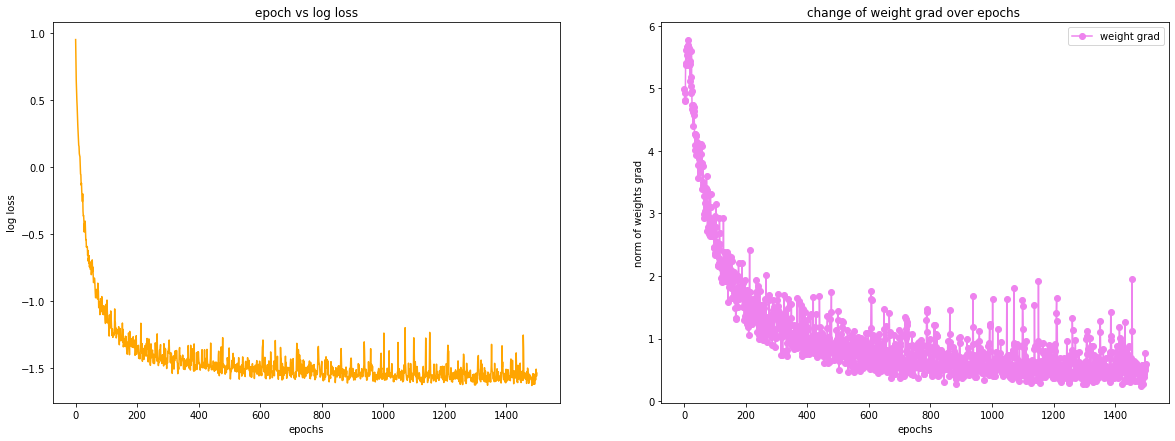

In [ ]:
plot(losssia,parsia)

In [ ]:
torch.save(modelSia,'D:/Saarland University/NNTI/project/models/modelSia.pt')

In [ ]:
# we then extract the trained CNN layers from the previous model
cnn=modelSia.convlay()
for param in cnn.parameters():
    param.requires_grad = True
cnn.to('cuda')

Sequential(
  (0): Conv1d(13, 26, kernel_size=(3,), stride=(1,), padding=same, bias=False)
  (1): Dropout(p=0.2, inplace=False)
  (2): Conv1d(26, 26, kernel_size=(3,), stride=(1,), padding=same, bias=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv1d(26, 52, kernel_size=(3,), stride=(1,), padding=same, bias=False)
  (8): Dropout(p=0.2, inplace=False)
  (9): Conv1d(52, 52, kernel_size=(3,), stride=(1,), padding=same, bias=False)
  (10): Dropout(p=0.2, inplace=False)
  (11): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv1d(52, 104, kernel_size=(3,), stride=(1,), padding=same, bias=False)
  (15): Dropout(p=0.2, inplace=False)
  (16): Conv1d(104, 104, kernel_siz

In [ ]:
dummy=np.zeros((1,melspectrogram.shape[0],maxlength+27))
datadict = {'TRAIN':dummy,'DEV':dummy,'TEST':dummy}
labeldict = {'TRAIN':[],'DEV':[],'TEST':[]}
for path,split,label in zip(sdr_df['file'],sdr_df['split'],sdr_df['label']):
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1)
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)
train_data = datadict['TRAIN'][1:]
test_data = datadict['TEST'][1:]
val_data = datadict['DEV'][1:]
train_y = labeldict['TRAIN']
test_y = labeldict['TEST']
val_y = labeldict['DEV']

In [ ]:
## same as the one for cnn architecture
custom_train_dataset = customDataset(train_data, train_y)
custom_train_loader = customDataLoader(custom_train_dataset, batch_size=32)
traindl = custom_train_loader.loader()

custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=503)
testdl = custom_test_loader.loader()

custom_val_dataset = customDataset(val_data, val_y)
custom_val_loader = customDataLoader(custom_val_dataset, batch_size=32)
valdl = custom_val_loader.loader()

In [ ]:
#creating the network for the downsample task
downmodel=downsample(cnn)
downmodel.to('cuda')


downsample(
  (conv_layers): Sequential(
    (0): Conv1d(13, 26, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (1): Dropout(p=0.2, inplace=False)
    (2): Conv1d(26, 26, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv1d(26, 52, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv1d(52, 52, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv1d(52, 104, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (15): Drop

In [ ]:
lossdown=[]
pardown=[]

In [ ]:
total_params = sum(p.numel() for p in downmodel.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 237786


In [ ]:
loss5,par5=downmodel.train(traindl,epochs = 100,learning_rate=0.001,lam=la,opti=optim) #100-0.01 #500-0.005 #500 - 0.001 #500 - 0.0001 #500 0.00005
lossdown+=loss5
pardown+=par5
print(test(downmodel,valdl))

epoch: 0 loss: 1.6290206909179688 grad: 0.5567023538995504
epoch: 1 loss: 1.5570411682128906 grad: 0.08987300841666486
epoch: 2 loss: 1.4683914184570312 grad: 0.11508636128723135
epoch: 3 loss: 1.4616585969924927 grad: 0.02141493692623239
epoch: 4 loss: 1.4624667167663574 grad: 0.04217420989926727
epoch: 5 loss: 1.4619059562683105 grad: 0.020649170101511787
epoch: 6 loss: 1.4630279541015625 grad: 0.04145168013504223
epoch: 7 loss: 1.4628103971481323 grad: 0.021264579339886257
epoch: 8 loss: 1.461591124534607 grad: 0.024334570534639614
epoch: 9 loss: 1.462347149848938 grad: 0.06738515776248596
epoch: 10 loss: 1.4614243507385254 grad: 0.01690831811324093
epoch: 11 loss: 1.46139395236969 grad: 0.017663857418671967
epoch: 12 loss: 1.4617739915847778 grad: 0.015056364516263092
epoch: 13 loss: 1.4611663818359375 grad: 0.0010203646813270726
epoch: 14 loss: 1.4635556936264038 grad: 0.015881893945867462
epoch: 15 loss: 1.4625413417816162 grad: 0.014439145118542102
epoch: 16 loss: 1.461798429489

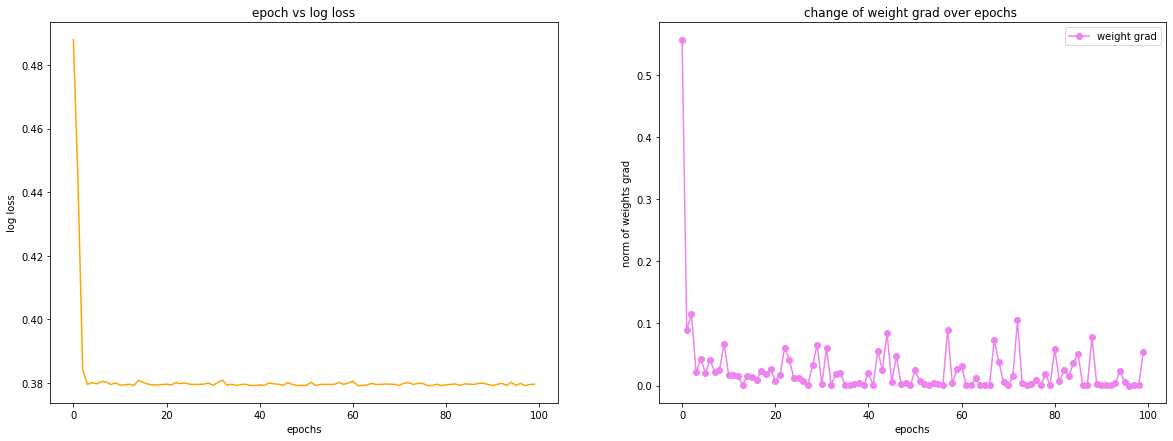

In [ ]:
plot(lossdown,pardown)

T-SNE plot on the testing dataset: 


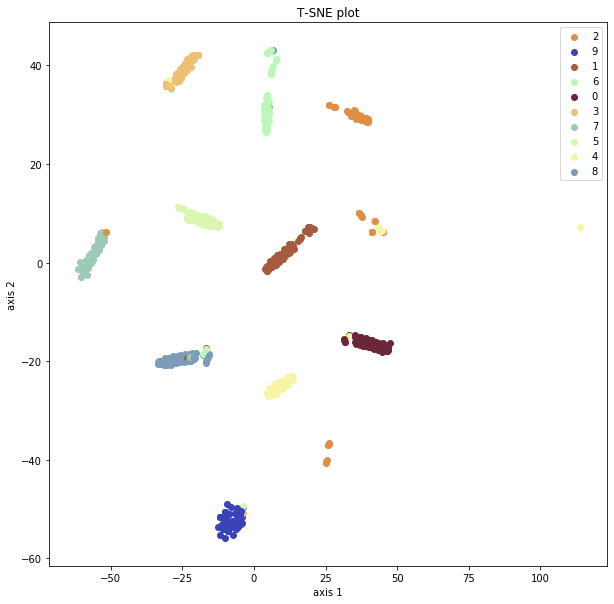

In [ ]:
print("T-SNE plot on the testing dataset: ")
tsne_map(testdl,downmodel)

In [ ]:
print("Training accuracy:")
get_accuracy(traindl,downmodel)
print("validation accuracy:")
get_accuracy(valdl,downmodel)

Training accuracy:
99.80000257492065 %
validation accuracy:
93.36015582084656 %


0.9336015582084656

In [ ]:
print("Loss on test:")
test(downmodel,testdl)
print("Training accuracy:")
get_accuracy(traindl,downmodel)
print("Test accuracy:")
get_accuracy(testdl,downmodel)
print("Training f1 score:")
get_f1(traindl,downmodel)
print("Test f1 score:")
get_f1(testdl,downmodel)

Loss on test:
1.5068379640579224
Training accuracy:
99.9500036239624 %
Test accuracy:
94.43339705467224 %
Training f1 score:
F1 score: 0.031484375
Test f1 score:
F1 score: 0.0018813560307618402


0.9463220834732056

confusion matrix on the test dataset:


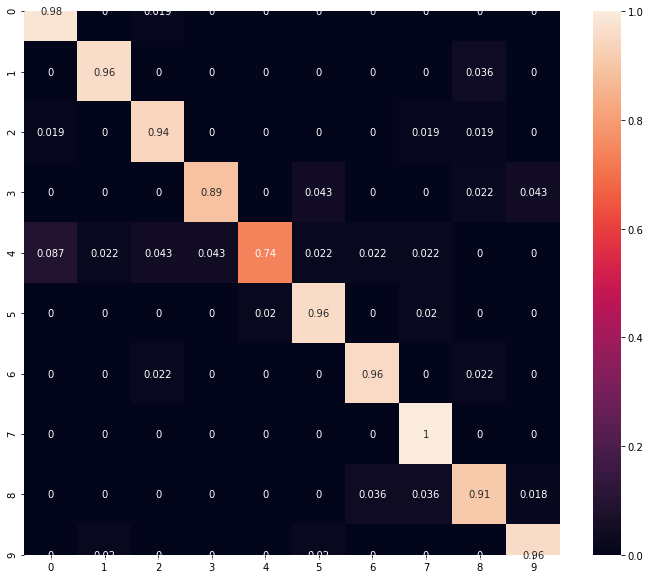

In [ ]:
print("confusion matrix on the test dataset:")
confusionplot(testdl,downmodel)

In [ ]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl,downmodel)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.93      0.96      0.94        53
           1       0.98      0.98      0.98        55
           2       0.98      1.00      0.99        54
           3       0.98      0.91      0.94        46
           4       1.00      0.80      0.89        46
           5       0.98      1.00      0.99        50
           6       0.96      0.93      0.95        46
           7       0.90      1.00      0.95        47
           8       0.97      1.00      0.98        56
           9       0.94      0.98      0.96        50

    accuracy                           0.96       503
   macro avg       0.96      0.96      0.96       503
weighted avg       0.96      0.96      0.96       503

